**Table of contents**<a id='toc0_'></a>    
- [Initial Tests with OFC](#toc1_)    
  - [Plotting PSD](#toc1_1_)    
  - [Getting FlatComb](#toc1_2_)    
- [Neural Network Training - PyTorch](#toc2_)    
  - [Datasets](#toc2_1_)    
  - [Forward Network](#toc2_2_)    
    - [Saved Results](#toc2_2_1_)    
    - [Test Phase](#toc2_2_2_)    
  - [Inverse Network](#toc2_3_)    
    - [Saved Results](#toc2_3_1_)    
    - [Test Phase](#toc2_3_2_)    
- [Bayesian Optimization](#toc3_)    
  - [Forward Network](#toc3_1_)    
  - [Inverse Network](#toc3_2_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import scienceplots
from ofc_functions import *
from nn_functions import *
import os, glob

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

In [2]:
#Trying to use CUDA
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Runnning in {device}")

Runnning in cuda


In [3]:
# Parameters for the OFC signal
ofc_args = parameters()

ofc_args.SpS = 64            # Samples per symbol 
ofc_args.Rs  = 10e9          # Symbol rate (baud rate - symbols per second)
ofc_args.Ts  = 1/ofc_args.Rs          # Symbol period (s)
ofc_args.Fa  = 1/(ofc_args.Ts/ofc_args.SpS)    # Sampling frequency of the signal (samples per second)
ofc_args.Ta  = 1/ofc_args.Fa          # Sampling period of the signal (s)
ofc_args.NFFT = ofc_args.SpS*256      # Number of points of the FFT (multiple of SpS) 
ofc_args.t = torch.arange(0, ofc_args.SpS*500).to(device)*ofc_args.Ta # Time vector for the signal (s)
ofc_args.Vpi = 2             # Voltage required to achieve a π phase shift (V)
#ofc_args.Vpi_IM = 5.5             # Voltage required to achieve a π phase shift (V)
#ofc_args.Vpi_PM = 3.5            # Voltage required to achieve a π phase shift (V)

ofc_args.P = 1              # Amplitude of the laser optical field
ofc_args.n_peaks = 11       # Number of peaks to be found in the signal

# Parameters for the modulators cascaded
mod_args = parameters()
mod_args.V_min = 0 # Minimum amplitude voltage (V)
mod_args.V_max = 3 # Maximum amplitude voltage (V)
mod_args.Phase_min = 0 # Minimum phase (rad)
mod_args.Phase_max = 2*torch.pi # Maximum phase (rad) --> Phase is periodic with period 2*π
#mod_args.Phase_max = 10*2*torch.pi # Maximum phase (rad)
mod_args.Vb_min = 0 # Minimum bias voltage (V)
mod_args.Vb_max = 4*ofc_args.Vpi # Maximum bias voltage (V) --> Vb is periodic with period 4*Vπ
#args.Vb_max = 10*4*args.Vpi # Maximum bias voltage (V)
mod_args.bounds = [(mod_args.V_min,mod_args.V_max),(mod_args.V_min,mod_args.V_max),(mod_args.V_min,mod_args.V_max), 
        (mod_args.Phase_min, mod_args.Phase_max),(mod_args.Phase_min, mod_args.Phase_max), (mod_args.Phase_min, mod_args.Phase_max),
        (mod_args.Vb_min,mod_args.Vb_max), (mod_args.Vb_min,mod_args.Vb_max)] # Bounds of the parameters

#mod_args.bounds = [(mod_args.V_min,mod_args.V_max),(mod_args.V_min,mod_args.V_max),(mod_args.V_min,mod_args.V_max), 
#        (mod_args.Phase_min, mod_args.Phase_max),(mod_args.Phase_min, mod_args.Phase_max), (mod_args.Phase_min, mod_args.Phase_max),
#        (mod_args.Vb_min,mod_args.Vb_max)] # Bounds of the parameters

freqs_peaks_GHz = torch.linspace(-(ofc_args.n_peaks//2),ofc_args.n_peaks//2,ofc_args.n_peaks) # Frequency range in GHz for n_peaks

# <a id='toc1_'></a>[Initial Tests with OFC](#toc0_)

## <a id='toc1_1_'></a>[Plotting PSD](#toc0_)

In [ ]:
def plot_signalPower_and_frequencyComb(V1, V2, V3, Phase1, Phase2, Phase3, Vb2, Vb3):
    
    params = V1, V2, V3, Phase1, Phase2, Phase3, Vb2, Vb3
    params = torch.tensor(params).unsqueeze(0).to(device)

    frequencyComb = frequencyCombGenerator_MZM_MZM_PM(params, ofc_args.Rs, ofc_args.t, ofc_args.P, ofc_args.Vpi)
    #frequencyComb = frequencyCombGenerator_PM_PM_MZM(params, ofc_args.Rs, ofc_args.t, ofc_args.P, ofc_args.Vpi)
    #frequencyComb = frequencyCombGenerator_DDMZM(params, ofc_args.Rs, ofc_args.t, ofc_args.P, ofc_args.Vpi)

    _, ax = plt.subplots(2,2,figsize = (10,6))

    power = torch.abs(frequencyComb.squeeze().cpu())**2
    ax[0,0].plot(ofc_args.t.squeeze().cpu()[:ofc_args.SpS*4]*1e9, power[:ofc_args.SpS*4], label = "Optical Signal")
    ax[0,0].set_xlabel("Time (ns)")
    ax[0,0].set_ylabel("Power (W)")
    ax[0,0].set_xlim(0,4*ofc_args.Ts*1e9)
    ax[0,0].set_ylim(0,1)
    ax[0,0].legend(loc='upper right')
    ax[0,0].grid()

    phase = np.unwrap(torch.angle(frequencyComb.squeeze()).cpu())
    ax[0,1].plot(ofc_args.t.squeeze().cpu()[:ofc_args.SpS*4]*1e9, phase[:ofc_args.SpS*4], label = "Optical Signal")
    ax[0,1].set_xlabel("Time (ns)")
    ax[0,1].set_ylabel("Phase (rad)")
    ax[0,1].set_xlim(0,4*ofc_args.Ts*1e9)
    ax[0,1].set_ylim(-5*torch.pi,5*torch.pi)
    ax[0,1].legend(loc='upper right')
    ax[0,1].grid()
    
    Pxx, freqs = get_psd_ByFFT(frequencyComb, ofc_args.Fa, ofc_args.NFFT)
    log_Pxx = 10*torch.log10(Pxx)
    peaks, indx = get_indx_peaks(log_Pxx, ofc_args.NFFT/ofc_args.SpS, ofc_args.n_peaks)

    ax[1,0].plot(freqs.squeeze().cpu()/ofc_args.Rs, log_Pxx.squeeze().cpu(), label = "Optical Signal Spectrum")
    ax[1,0].plot(freqs[indx].squeeze().cpu()/ofc_args.Rs, peaks.squeeze().cpu(), 'o')
    ax[1,0].set_xlim(-15,15)
    ax[1,0].set_ylim(-200,-50)
    ax[1,0].legend(loc='lower right');
    ax[1,0].set_xlabel("Frequency (GHz) - Normalized to symbol rate");
    ax[1,0].set_ylabel("Power (dB/Hz)")
    ax[1,0].grid()
    
    mean = torch.mean(peaks.squeeze()).cpu().numpy()
    var = torch.var(peaks.squeeze()).cpu().numpy()

    x_array = np.array([freqs.squeeze().cpu().numpy()[0],freqs[-1].squeeze().cpu().numpy()])/ofc_args.Rs
    ax[1,0].plot(x_array, np.array([1,1])*mean, "--",label = "peaks mean")
    ax[1,0].plot(x_array, np.array([1,1])*(mean+np.sqrt(var)), "--",label = "peaks max")
    ax[1,0].plot(x_array, np.array([1,1])*(mean-np.sqrt(var)), "--",label = "peaks min")

    ax[1,1].axis('off')
    ax[1,1].text(0, 0.7, "Mean: %.2f dB" %mean, fontsize=10)
    ax[1,1].text(0, 0.6, "Standard Deviation: %.2f dB" %np.sqrt(var), fontsize=10)
    ax[1,1].text(0, 0.4, "Variance: %.4f dB^2"%var, fontsize=12)
    ax[1,1].text(0, 0.3, "max - min: %.4f dB" %(torch.max(peaks.squeeze().cpu()) - torch.min(peaks.squeeze().cpu())), fontsize=12)

    plt.tight_layout()
    plt.show()

In [ ]:
import ipywidgets as widgets

initial_values = [ 2.39532993e+00,  2.14083606e+00,  1.74865649e+00,  3.09513887e+00, 3.09518252e+00,  3.09526099e+00,  3.00775498e+00, -1.11022302e-20]

V1     = widgets.FloatSlider(value=initial_values[0], min=mod_args.V_min,     max=mod_args.V_max,    step = 0.001, description = 'V1')
V2     = widgets.FloatSlider(value=initial_values[1], min=mod_args.V_min,     max=mod_args.V_max,    step = 0.001, description = 'V2')
V3     = widgets.FloatSlider(value=initial_values[2], min=mod_args.V_min,     max=mod_args.V_max,    step = 0.001, description = 'V3')
Phase1 = widgets.FloatSlider(value=initial_values[3], min=mod_args.Phase_min, max=mod_args.Phase_max,step = 0.001, description = 'Phase1')
Phase2 = widgets.FloatSlider(value=initial_values[4], min=mod_args.Phase_min, max=mod_args.Phase_max,step = 0.001, description = 'Phase2')
Phase3 = widgets.FloatSlider(value=initial_values[5], min=mod_args.Phase_min, max=mod_args.Phase_max,step = 0.001, description = 'Phase3')
Vb2    = widgets.FloatSlider(value=initial_values[6], min=mod_args.Vb_min,    max=mod_args.Vb_max,   step = 0.001, description = 'Vb2')
Vb3    = widgets.FloatSlider(value=initial_values[7], min=mod_args.Vb_min,    max=mod_args.Vb_max,   step = 0.001, description = 'Vb3')

ui1 = widgets.HBox([V1, V2, V3, Vb2])
ui2 = widgets.HBox([Phase1, Phase2, Phase3, Vb3])
out1 = widgets.interactive_output(plot_signalPower_and_frequencyComb, {'V1': V1, 'V2': V2,'V3':V3,'Phase1':Phase1, 'Phase2':Phase2, 'Phase3':Phase3,'Vb2': Vb2, 'Vb3': Vb3})

display(ui1, ui2, out1)

## <a id='toc1_2_'></a>[Getting FlatComb](#toc0_)

In [ ]:
# Chute inicial para as configurações dos moduladores (amplitude e fase)
initial_guess = [1.5, 1.5, 1.5, np.pi, np.pi, np.pi, 3, 0]
#initial_guess = [2.7894168, 2.6391733, 0.7795948, 3.1160705, 3.2805085, 3.265839,  6.7473345, 0]

optimized_params,_, _ = optimization_flatComb(initial_guess, args = ofc_args, bounds = mod_args.bounds, method = "COBYLA")
V1, V2, V3, Phase1, Phase2, Phase3, Vb2, Vb3 = optimized_params

# Exibir as configurações otimizadas
print("Configurações otimizadas:")
print(f"V1: {V1:.4f} V")
print(f"V2: {V2:.4f} V")
print(f"V3: {V3:.4f} V")
print(f"Phase1: {Phase1:.4f} rad")
print(f"Phase2: {Phase2:.4f} rad")
print(f"Phase3: {Phase3:.4f} rad")
print(f"Vb2: {Vb2:.4f} V")
print(f"Vb3: {Vb3:.4f} V")

In [ ]:
initial_values = [ 2.39532993e+00,  2.14083606e+00,  1.74865649e+00,  3.09513887e+00, 3.09518252e+00,  3.09526099e+00,  3.00775498e+00, -1.11022302e-20]
plot_signalPower_and_frequencyComb(*initial_values)


In [ ]:
plot_signalPower_and_frequencyComb(*optimized_params)

# <a id='toc2_'></a>[Neural Network Training - PyTorch](#toc0_)

## <a id='toc2_1_'></a>[Datasets](#toc0_)

In [4]:
train_nsamples = 300000          # Number of samples for training   (80%)
val_nspamples  = train_nsamples//8  # Number of samples for validation (10%)
test_nsamples  = train_nsamples//8  # Number of samples for testing    (10%)

In [5]:
#load datasets if they exist, create them otherwise
datasets_folder = "saved_data/datasets/"
gen = "mzm_mzm_pm_"
dataset_name = gen + f"{train_nsamples*1e-3:.0f}k_samples"
train_filename = datasets_folder + "train_dataset_" + dataset_name + ".pt"
test_filename = datasets_folder + "test_dataset_" + dataset_name + ".pt"
val_filename = datasets_folder + "val_dataset_" + dataset_name + ".pt"

if os.path.exists(train_filename) and os.path.exists(test_filename) and os.path.exists(val_filename):
    print("Loading datasets...")
    train_dataset = torch.load(train_filename)
    test_dataset = torch.load(test_filename)
    val_dataset = torch.load(val_filename)
    print("Datasets loaded!")
else:
    print("Creating datasets...")
    train_dataset = FrequencyCombDataset(frequencyCombPeaks, train_nsamples, ofc_args = ofc_args, bounds = mod_args.bounds, device = device, zero_mean=True)
    test_dataset  = FrequencyCombDataset(frequencyCombPeaks, test_nsamples,  ofc_args = ofc_args, bounds = mod_args.bounds, norm_scales=train_dataset.norm_scales, device = device, zero_mean=train_dataset.zero_mean)
    val_dataset   = FrequencyCombDataset(frequencyCombPeaks, val_nspamples,  ofc_args = ofc_args, bounds = mod_args.bounds, norm_scales=train_dataset.norm_scales, device = device, zero_mean=train_dataset.zero_mean)
    print("Datasets created!")

    torch.save(train_dataset, train_filename)
    torch.save(test_dataset, test_filename)
    torch.save(val_dataset, val_filename)
    print("Datasets saved!")


Loading datasets...
Datasets loaded!


### <a id='toc2_1_1_'></a>[Add FlatCombs](#toc0_)

In [ ]:
files = glob.glob(datasets_folder + gen + 'flatComb_*')
if len(files) > 0:
    print("Loading flatComb datasets...")
    flatComb_inputs0_1dB = np.load(glob.glob(datasets_folder + gen + "flatComb_inputs0_1dB_*")[0])
    flatComb_outputs0_1dB = np.load(glob.glob(datasets_folder + gen + "flatComb_outputs0_1dB_*")[0])

    flatComb_inputs1_5dB = np.load(glob.glob(datasets_folder + gen + "flatComb_inputs1_5dB_*")[0])
    flatComb_outputs1_5dB = np.load(glob.glob(datasets_folder + gen + "flatComb_outputs1_5dB_*")[0])

    for file in files:
        print(file) 
    print("FlatComb datasets loaded!")

else:
    max_flat_samples = 10

    print("Creating flatComb datasets...")
    flatComb_inputs0_1dB, flatComb_outputs0_1dB, flatComb_inputs1_5dB, flatComb_outputs1_5dB = create_flatCombs(max_flat_samples, args = ofc_args, bounds = mod_args.bounds, )

    #save flatComb_inputs and flatComb_outputs
    np.save(datasets_folder + gen + f"flatComb_inputs0_1dB_{len(flatComb_inputs0_1dB)}.npy", flatComb_inputs0_1dB)
    np.save(datasets_folder + gen + f"flatComb_outputs0_1dB_{len(flatComb_outputs0_1dB)}.npy", flatComb_outputs0_1dB)

    np.save(datasets_folder + gen + f"flatComb_inputs1_5dB_{len(flatComb_inputs1_5dB)}.npy", flatComb_inputs1_5dB)
    np.save(datasets_folder + gen + f"flatComb_outputs1_5dB_{len(flatComb_outputs1_5dB)}.npy", flatComb_outputs1_5dB)

    print("FlatComb datasets created and saved!")

In [ ]:
#normalization
flatComb_outputs0_1dB = train_dataset.normalize(flatComb_outputs0_1dB)
flatComb_outputs1_5dB = train_dataset.normalize(flatComb_outputs1_5dB)

#split the flatComb data into train, test and validation
train_flatComb_inputs0_1dB, train_flatComb_outputs0_1dB, val_flatComb_inputs0_1dB, val_flatComb_outputs0_1dB, test_flatComb_inputs0_1dB, test_flatComb_outputs0_1dB = split_train_val_test_data(flatComb_inputs0_1dB, flatComb_outputs0_1dB, shuffle = True)
train_flatComb_inputs1_5dB, train_flatComb_outputs1_5dB, val_flatComb_inputs1_5dB, val_flatComb_outputs1_5dB, test_flatComb_inputs1_5dB, test_flatComb_outputs1_5dB = split_train_val_test_data(flatComb_inputs1_5dB, flatComb_outputs1_5dB, shuffle = True)

In [ ]:
#add the flatCombs (0-1dB) and combs 1-5dB data to the big datasets

train_dataset.input_tensors = torch.cat((train_dataset.input_tensors, train_flatComb_inputs0_1dB, train_flatComb_inputs1_5dB))
train_dataset.output_tensors = torch.cat((train_dataset.output_tensors, train_flatComb_outputs0_1dB, train_flatComb_outputs1_5dB))

val_dataset.input_tensors = torch.cat((val_dataset.input_tensors, val_flatComb_inputs0_1dB, val_flatComb_inputs1_5dB))
val_dataset.output_tensors = torch.cat((val_dataset.output_tensors, val_flatComb_outputs0_1dB, val_flatComb_outputs1_5dB))

test_dataset.input_tensors = torch.cat((test_dataset.input_tensors, test_flatComb_inputs0_1dB, test_flatComb_inputs1_5dB))
test_dataset.output_tensors = torch.cat((test_dataset.output_tensors, test_flatComb_outputs0_1dB, test_flatComb_outputs1_5dB))

In [ ]:
#add the flatCombs (0-1dB) and combs 1-5dB data to the big datasets

train_dataset.input_tensors = torch.cat((train_dataset.input_tensors, torch.from_numpy(train_flatComb_inputs0_1dB).float(), torch.from_numpy(train_flatComb_inputs1_5dB).float()))
train_dataset.output_tensors = torch.cat((train_dataset.output_tensors, torch.from_numpy(train_flatComb_outputs0_1dB).float(), torch.from_numpy(train_flatComb_outputs1_5dB).float()))

val_dataset.input_tensors = torch.cat((val_dataset.input_tensors, torch.from_numpy(val_flatComb_inputs0_1dB).float(), torch.from_numpy(val_flatComb_inputs1_5dB).float()))
val_dataset.output_tensors = torch.cat((val_dataset.output_tensors, torch.from_numpy(val_flatComb_outputs0_1dB).float(), torch.from_numpy(val_flatComb_outputs1_5dB).float()))

test_dataset.input_tensors = torch.cat((test_dataset.input_tensors, torch.from_numpy(test_flatComb_inputs0_1dB).float(), torch.from_numpy(test_flatComb_inputs1_5dB).float()))
test_dataset.output_tensors = torch.cat((test_dataset.output_tensors, torch.from_numpy(test_flatComb_outputs0_1dB).float(), torch.from_numpy(test_flatComb_outputs1_5dB).float()))

In [ ]:
count1=0
for i in range(len(train_dataset.output_tensors)):
    min_max = np.max(train_dataset.denormalize(train_dataset.output_tensors[i]).numpy()) - np.min(train_dataset.denormalize(train_dataset.output_tensors[i]).numpy())
    if min_max < 1:
        count1+=1
        
print(f"Porcentagem do dataset que é flat comb: {count1/len(train_dataset.output_tensors)*100:.2f}%")

## <a id='toc2_2_'></a>[Forward Network](#toc0_)

In [ ]:
# Create data loaders
batch_size = 10
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle=True)

In [ ]:
# Initialize the model
n_inputs = train_dataset.input_tensors.shape[1]
n_outputs = train_dataset.output_tensors.shape[1]
architecture = [n_inputs, 176, 176, 176, 176, 176, 176, 176, 176, n_outputs]

model = FrequencyCombNet(architecture).to(device)
model_name = "model_" + "_".join([f"{n:.0f}" for n in architecture]) + "_" + dataset_name + "_batch_size_" + f"{batch_size:.0f}"
model_path = "saved_data/models/"+ model_name +".pth"

# Loss Function
criterion = nn.MSELoss() # Mean Squared Error

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 8.5e-5) # lr - learning rate

# load model and optimizer if they exist
if os.path.exists(model_path):
    print("Loading model...")
    checkpoint = torch.load(model_path, map_location=torch.device(device))
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    print("Model and Optimizer loaded!")
else:
    print("No checkpoint to load!")
    print("Model and Optimizer created!")

In [ ]:
#architecture = [8, 296, 296, 296, 296, 296, 296, 11]
calc_num_params(architecture)

In [ ]:
# Training loop

## losses
train_losses_path = "saved_data/losses/" + model_name + '_train_losses.npy'
val_losses_path = "saved_data/losses/" + model_name + '_val_losses.npy'

# Load training losses if file exists
if os.path.exists(train_losses_path) and os.path.exists(val_losses_path):
    train_losses = list(np.load(train_losses_path))
    val_losses = list(np.load(val_losses_path))
    print("Losses files loaded!")
else:
    print("Losses files not found.")
    train_losses, val_losses = [], []
    print("Losses files created!")

In [ ]:

num_epochs = 10
val_loss_min = 1

PATIENCE = 50
patience_counter = 0
for epoch in range(1, num_epochs + 1):

    # Training phase
    avg_train_loss, _, _ = run_one_epoch_forward("train", train_loader, model, criterion, device, optimizer)
    train_losses.append(avg_train_loss) #Epoch training losses for plotting

    # Validation phase
    avg_val_loss, _, _ = run_one_epoch_forward("val", val_loader, model, criterion, device)
    val_losses.append(avg_val_loss) # Append average validation loss for the epoch

    # Early stopping
    if avg_val_loss > val_loss_min:

        patience_counter += 1
        if patience_counter >= PATIENCE:
            print(f"Early stopping at epoch {epoch}!")
            break
    else:
        patience_counter = 0

    #'''# Save model if validation loss has decreased
    if avg_val_loss <= val_loss_min:
        print(f'Validation loss decreased ({val_loss_min:.6f} --> {avg_val_loss:.6f}). Epoch: {epoch}. Saving model...')
        torch.save(model.state_dict(), model_name + "val_min.pth")
        val_loss_min = avg_val_loss
    #'''

    # Print training progress
    if(epoch%(num_epochs//10) == 0):
        real_train_losses, real_val_losses = convert_to_real_loss([avg_train_loss, avg_val_loss], train_dataset.norm_scales)
        print(f"Epoch: {epoch}/{num_epochs}.. Training loss: {real_train_losses:.6f} (dB/Hz)^2.. Validation Loss: {real_val_losses:.6f} (dB/Hz)^2")
        #plot_training_progress(real_train_losses, real_val_losses, ylabel = "Loss (dB/Hz)^2")
        plot_training_progress(np.log10(train_losses), np.log10(val_losses), ylabel = "log10(Loss)")



In [ ]:
# Save model
torch.save({"model_state_dict" : model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict()}, model_path)

# Save training and validation losses
np.save(train_losses_path, np.array(train_losses))
np.save(val_losses_path, np.array(val_losses))


In [ ]:
plot_training_progress_style(convert_to_real_loss(train_losses, train_dataset.norm_scales)[:], convert_to_real_loss(val_losses, train_dataset.norm_scales)[:], title = "", ylabel = r"$Erro\; (dB/Hz)^2$", ylim=(0,10), average_curves = False, M = 10)

### <a id='toc2_2_1_'></a>[Test Phase](#toc0_)

In [ ]:
def plot_comparison_style(target, output, freqs_GHz, loss, figname, title, ylim = (-35,35), xlabel = r"$Frequência\; Básica\; (em\; unidades\; de\; f_m)$", ylabel = r"$PSD\; (dB/Hz)$", show_max_min = False):
    with plt.style.context(['science', 'ieee', "grid", 'no-latex']):
        fig, ax = plt.subplots()
        ax.plot(freqs_GHz, target, "s", label=r'$Alvo$')
        ax.plot(freqs_GHz, output, "o", label=r'$Predição$')
        ax.legend()
        ax.autoscale(tight=True)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_xticks(freqs_GHz)
        ax.set_title(title)
        ax.set_xlim(freqs_GHz[0]-0.5,freqs_GHz[-1]+0.5)
        ax.set_ylim(ylim)

        text = fr"MSE: {loss:.3f} $(dB/Hz)^2$"
        if show_max_min:
            text += "\n" + fr"Max - Min: {np.max(output) - np.min(output):.3f} $dB$"
        ax.text(0, ylim[0]*0.88, text, ha = 'center', bbox=dict(facecolor='white', alpha=1, edgecolor='silver', boxstyle='round,pad=0.3'))
        #fig.savefig(figname, dpi=300)
        plt.show()
        plt.close()

In [ ]:
target

In [ ]:
# Test with flat comb

params = [2.7442043, 1.9302677, 2.4303038, 1.2577362, 0.7501987, 0.8391744, 2.0000486, 2.0055982e-06] # flat comb parameters
input = torch.tensor(params, dtype=torch.float32).unsqueeze(0).to(device)

target_non_norm = frequencyCombPeaks(params, ofc_args).unsqueeze(0).to(device)
target_non_norm = target_non_norm - torch.mean(target_non_norm)
target = train_dataset.normalize(target_non_norm)

data = zip(input, target)
loss, output, _ = run_one_epoch_forward("test", data, model, criterion, device)

# Denormalize
output = train_dataset.denormalize(output).cpu().detach().numpy().squeeze()
target = train_dataset.denormalize(target).cpu().detach().numpy().squeeze()
real_loss = convert_to_real_loss(loss, train_dataset.norm_scales)

# Plot the Comparison
title = "Testing a flat comb as model input"
title = ''
figname = 'fig_flatComb_forward'

plot_comparison_style(target, output, freqs_peaks_GHz, real_loss, figname, title, ylim = (-10,10), show_max_min=True)

In [ ]:
# Test phase
avg_test_loss, outputs, targets = run_one_epoch_forward("test", test_loader, model, criterion, device)
print(f"Test Loss: {convert_to_real_loss(avg_test_loss, train_dataset.norm_scales):.6f} (dB/Hz)^2")

for i in range(min(10, outputs.shape[0])):  # Loop over the first n examples

    # Denormalize
    outputs_denorm = train_dataset.denormalize(outputs[i])
    targets_denorm = train_dataset.denormalize(targets[i])
    real_loss = criterion(outputs_denorm, targets_denorm).item()

    # Plot the comparison
    #figname = f'fig_sample{i+1}_forward'
    title = f"Sample {i+1}"
    title = ''
    targets_denorm = targets_denorm.cpu().detach().numpy().squeeze()
    outputs_denorm = outputs_denorm.cpu().detach().numpy().squeeze()
    
    plot_comparison_style(targets_denorm, outputs_denorm, freqs_peaks_GHz, real_loss, figname, title, ylim = (-30,30))


## <a id='toc2_3_'></a>[Inverse Network](#toc0_)

In [ ]:
# Create data loaders
batch_size = 80
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle=True)

n_inputs = train_dataset.input_tensors.shape[1]
n_outputs = train_dataset.output_tensors.shape[1]

In [ ]:
# Load the pre-trained forward model
forward_net_name = 'model_8_176_176_176_176_176_176_176_176_11_mzm_mzm_pm_300k_samples_batch_size_80'
forward_net_path = "saved_data/models/" + forward_net_name + ".pth"
#forward_net_path = forward_net_name + ".pth"

model_dict_data = torch.load(forward_net_path, map_location=torch.device(device))
forward_architecture = get_architecture(model_dict_data)
forward_net = FrequencyCombNet(forward_architecture).to(device)
forward_net.load_state_dict(model_dict_data["model_state_dict"])  # Load pre-trained weights
forward_net.eval()  # Set model to evaluation mode

for p in forward_net.parameters():
    p.requires_grad = False  # Freeze the weights and biases

# Create an inverse model
#inverse_architecture = forward_architecture[::-1]
inverse_architecture = [n_outputs, 345, 345, 345, 345, 345,345, n_inputs]

inverse_net = FrequencyCombNet(inverse_architecture).to(device)

inverse_net_name = "model_" + "_".join([f"{n:.0f}" for n in inverse_architecture]) + "_" + dataset_name + "_batch_size_" + f"{batch_size:.0f}"+ "inverse_net"
inverse_net_path = "saved_data/models/"+ inverse_net_name +".pth"

# Loss Function
criterion = nn.MSELoss() # Mean Squared Error

# Optimizer
inv_optimizer = torch.optim.Adam(inverse_net.parameters(), lr = 7.97e-5) # lr - learning rate

# load model and optimizer if they exist
if os.path.exists(inverse_net_path):
    print("Loading model...")
    checkpoint = torch.load(inverse_net_path, map_location=torch.device(device))
    inverse_net.load_state_dict(checkpoint['model_state_dict'])
    inv_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    print(inverse_net_name)
    print("Model and Optimizer loaded!")
else:
    print("No checkpoint to load!")
    print("Model and Optimizer created!")

In [ ]:

calc_num_params(inverse_architecture)

In [ ]:
## losses
inv_train_losses_path = "saved_data/losses/" + inverse_net_name + '_train_losses.npy'
inv_val_losses_path = "saved_data/losses/" + inverse_net_name + '_val_losses.npy'

# Load training losses if file exists
if os.path.exists(inv_train_losses_path) and os.path.exists(inv_val_losses_path):
    train_losses = list(np.load(inv_train_losses_path))
    val_losses = list(np.load(inv_val_losses_path))
    print("Losses files loaded!")
else:
    print("Losses files not found.")
    train_losses, val_losses = [], []
    print("Losses files created!")

In [ ]:
flat_val_losses = []

In [ ]:
num_epochs = 300
#val_loss_min = 1
#min_test_loss = 0.5

PATIENCE = 50
patience_counter = 0

for epoch in range(1, num_epochs + 1):

    # Training phase
    avg_train_loss, _, _, _, _ = run_one_epoch_inverse("train", train_loader, forward_net, inverse_net, criterion, device, inv_optimizer)
    train_losses.append(avg_train_loss)

    # Validation phase
    avg_val_loss, _, _, _, _ = run_one_epoch_inverse("val", val_loader, forward_net, inverse_net, criterion, device)
    val_losses.append(avg_val_loss)  # Append average validation loss for the epoch


    # Print training progress
    if(epoch%(num_epochs//10) == 0):
        print(f"Epoch: {epoch}/{num_epochs}... Training loss: {convert_to_real_loss(avg_train_loss, train_dataset.norm_scales):.6f} (dB/Hz)^2 ... Validation Loss: {convert_to_real_loss(avg_val_loss, train_dataset.norm_scales):.6f} (dB/Hz)^2")
        plot_training_progress(np.log10(train_losses), np.log10(val_losses), ylabel = "log10(Loss)")

    #'''
    # Save model if validation loss has decreased
    if avg_val_loss <= val_loss_min:
        print(f'Validation loss decreased ({val_loss_min:.6f} --> {avg_val_loss:.6f}). Epoch: {epoch}. Saving model...')
        torch.save(inverse_net.state_dict(), inverse_net_name + "val_min.pth")
        val_loss_min = avg_val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print(f'Early stopping at epoch {epoch} with validation loss: {avg_val_loss:.6f}')
            break
    #''' 

    # Test FlatComb
    perfect_flat_comb = torch.tensor([-90]*n_outputs).unsqueeze(0).to(device)
    perfect_flat_comb = perfect_flat_comb - torch.mean(perfect_flat_comb, dtype=torch.float32)
    perfect_flat_comb = train_dataset.normalize(perfect_flat_comb)

    perfect_flat_comb_inv_output = inverse_net(perfect_flat_comb)

    inverse_peaks = torch.tensor(frequencyCombPeaks(perfect_flat_comb_inv_output.cpu().detach().numpy().squeeze(), ofc_args), dtype=torch.float32).unsqueeze(0).to(device)
    inverse_peaks = inverse_peaks - torch.mean(inverse_peaks)
    inverse_peaks = train_dataset.normalize(inverse_peaks)

    inv_loss = criterion(perfect_flat_comb, inverse_peaks).item()
    inv_loss = convert_to_real_loss(inv_loss, train_dataset.norm_scales).item()

    flat_val_losses.append(inv_loss)  # Append average validation loss for the epoch

    if inv_loss < min_test_loss:
        min_test_loss = inv_loss
        print(f"Epoch: {epoch}/{num_epochs}... Test loss: {inv_loss:.6f} (dB/Hz)^2 .. validation loss: {avg_val_loss:.6f}")
        torch.save(inverse_net.state_dict(), inverse_net_name + "_min_flat_loss.pth")
        
    if inv_loss < 0.1:
        print(f"Epoch: {epoch}/{num_epochs}... Test loss: {inv_loss:.6f} (dB/Hz)^2 .. validation loss: {avg_val_loss:.6f}")

        #break


In [ ]:
plt.plot(flat_val_losses[10:])
plt.ylim(0,2)
#plt.xlim(460,470)

In [ ]:
# Save model
torch.save({"model_state_dict" : inverse_net.state_dict(),
            "optimizer_state_dict": inv_optimizer.state_dict()}, inverse_net_path)

# Save training and validation losses for the inverse model
np.save(inv_train_losses_path, np.array(train_losses))
np.save(inv_val_losses_path, np.array(val_losses))

In [ ]:
#load min flat loss model
model_dict_data = torch.load(inverse_net_name + "_min_flat_loss.pth", map_location=torch.device(device))
inverse_net.load_state_dict(model_dict_data)  # Load pre-trained weights

In [ ]:
#load the min loss
checkpoint = torch.load(inverse_net_name + "val_min.pth", map_location=torch.device(device))
inverse_net.load_state_dict(checkpoint)


In [ ]:
plot_training_progress_style(convert_to_real_loss(train_losses, train_dataset.norm_scales)[:], convert_to_real_loss(val_losses, train_dataset.norm_scales)[:], title = "",  average_curves = False, figname = "losses_mmp_inverse.png")

### <a id='toc2_3_1_'></a>[Test Phase](#toc0_)

In [ ]:
# Test phase

perfect_flat_comb = torch.tensor([-90]*n_outputs).unsqueeze(0).to(device) #flat comb
#perfect_flat_comb = torch.tensor([-80,-85,-90,-95,-100,-105,-100,-95,-90,-85,-80]).unsqueeze(0).to(device) #alternating comb
#perfect_flat_comb = torch.tensor(0.5*np.arange(-5,6,1)**2, dtype=torch.float32).unsqueeze(0).to(device) #quadratic comb
#perfect_flat_comb = torch.tensor(200*np.exp(-0.01*np.arange(-5,6,1)**2), dtype=torch.float32).unsqueeze(0).to(device) #gaussian comb 
#perfect_flat_comb = torch.tensor(-60*np.exp(-0.01*np.arange(-5,6,1)**2), dtype=torch.float32).unsqueeze(0).to(device) #gaussian comb negative
#perfect_flat_comb = torch.tensor(-np.abs(8*np.arange(-5,6,1)), dtype=torch.float32).unsqueeze(0).to(device) #hate comb
#perfect_flat_comb = torch.tensor(3.6*np.arange(-5,6,1), dtype=torch.float32).unsqueeze(0).to(device) # linear comb
#perfect_flat_comb = -2.5*torch.tensor([-80,-85,-80,-85,-80,-85,-80,-85,-80,-85,-80]).unsqueeze(0).to(device) #alternating comb
#perfect_flat_comb[0,5]= -115 #hole

perfect_flat_comb = perfect_flat_comb - torch.mean(perfect_flat_comb, dtype=torch.float32)
perfect_flat_comb = train_dataset.normalize(perfect_flat_comb)

perfect_flat_comb_inv_output = inverse_net(perfect_flat_comb)

inverse_peaks = torch.tensor(frequencyCombPeaks(perfect_flat_comb_inv_output.cpu().detach().numpy().squeeze(), ofc_args), dtype=torch.float32).unsqueeze(0).to(device)
inverse_peaks = inverse_peaks - torch.mean(inverse_peaks)
inverse_peaks = train_dataset.normalize(inverse_peaks)

loss = criterion(perfect_flat_comb, inverse_peaks).item()
real_loss = convert_to_real_loss(loss, train_dataset.norm_scales).item()

perfect_flat_comb_denorm = train_dataset.denormalize(perfect_flat_comb).cpu().detach().numpy().squeeze()
inverse_peaks_denorm = train_dataset.denormalize(inverse_peaks).cpu().detach().numpy().squeeze()

# Plot the Comparison
title = "Testing the inverse model with a perfect flat comb as input"
title = ''
figname = 'figures/fig_inverse_flat_comb'
figname = 'figures/fig_inverse_hat_comb'
figname = 'figures/fig_inverse_hole_comb'
figname = 'figures/inverseNet_sample3'
figname = 'figures/fig_inverse_flat_comb'
figname = 'figures/fig_inverse_linear_comb'
figname = 'figures/fig_inverse_gaussian_comb'


#plot_comparison_style(perfect_flat_comb_denorm, inverse_peaks_denorm, freqs_peaks_GHz, real_loss, figname, title, show_max_min=True, ylim = (-3,3))
plot_comparison_style(perfect_flat_comb_denorm, inverse_peaks_denorm, freqs_peaks_GHz, real_loss, figname, title, show_max_min=False)

In [ ]:
# Test with flat comb

params = [2.7442043, 1.9302677, 2.4303038, 1.2577362, 0.7501987, 0.8391744, 2.0000486, 2.0055982e-06] # flat comb parameters

input = torch.tensor(params, dtype=torch.float32).unsqueeze(0).to(device)
target_non_norm = torch.tensor(frequencyCombPeaks(params, ofc_args), dtype=torch.float32).unsqueeze(0).to(device)
target_non_norm = target_non_norm - torch.mean(target_non_norm)
target = train_dataset.normalize(target_non_norm)

data = zip(input, target)
inv_for_loss, forward_output, inverse_output, _, _ = run_one_epoch_inverse("test", data, forward_net, inverse_net, criterion, device)

inverse_peaks = torch.tensor(frequencyCombPeaks(inverse_output.cpu().detach().numpy(), ofc_args), dtype=torch.float32).unsqueeze(0).to(device)
inverse_peaks = inverse_peaks - torch.mean(inverse_peaks)
inverse_peaks = train_dataset.normalize(inverse_peaks)

# Denormalize
inv_loss = criterion(inverse_peaks, target).item()
inverse_peaks_denorm = train_dataset.denormalize(inverse_peaks).cpu().detach().numpy().squeeze()
target_denorm = train_dataset.denormalize(target).cpu().detach().numpy().squeeze()
forward_output_denorm = train_dataset.denormalize(forward_output).cpu().detach().numpy().squeeze()
inv_loss_real = convert_to_real_loss(inv_loss, train_dataset.norm_scales)
inv_for_loss_real = convert_to_real_loss(inv_for_loss, train_dataset.norm_scales)

# Plot the Comparison
title = "Testing a flat comb as model input"
figname = 'fig_flatComb_inverseNet.jpg'
plot_comparison(target_denorm, inverse_peaks_denorm, freqs_peaks_GHz, inv_loss_real, figname, title)

In [ ]:
# Test phase
avg_test_loss, inv_for_outputs, inverse_outputs, targets, inputs = run_one_epoch_inverse("test", train_loader, forward_net, inverse_net, criterion, device)
print(f"Test Loss: {convert_to_real_loss(avg_test_loss, train_dataset.norm_scales):.6f} (dB/Hz)^2")

In [ ]:
# Test phase
avg_test_loss, inv_for_outputs, inverse_outputs, targets, inputs = run_one_epoch_inverse("test", val_loader, forward_net, inverse_net, criterion, device)
print(f"Test Loss: {convert_to_real_loss(avg_test_loss, train_dataset.norm_scales):.6f} (dB/Hz)^2")

In [ ]:

# Test phase
avg_test_loss, inv_for_outputs, inverse_outputs, targets, inputs = run_one_epoch_inverse("test", test_loader, forward_net, inverse_net, criterion, device)
print(f"Test Loss: {convert_to_real_loss(avg_test_loss, train_dataset.norm_scales):.6f} (dB/Hz)^2")

# Loop over the first n examples
for i in range(min(10, targets.shape[0])):

    inverse_peaks = torch.tensor(frequencyCombPeaks(inverse_outputs[i].cpu().detach().numpy(), ofc_args), dtype=torch.float32).to(device)
    inverse_peaks = inverse_peaks - torch.mean(inverse_peaks)
    inverse_peaks = train_dataset.normalize(inverse_peaks)

    forward_peaks = forward_net(inputs[i])
    
    # Denormalize
    inv_for_outputs_denorm = train_dataset.denormalize(inv_for_outputs[i])
    targets_denorm = train_dataset.denormalize(targets[i])
    inverse_peaks_denorm = train_dataset.denormalize(inverse_peaks)
    forward_peaks_denorm = train_dataset.denormalize(forward_peaks)

    inv_for_loss = criterion(inv_for_outputs_denorm, targets_denorm).item()
    inverse_loss = criterion(inverse_peaks_denorm, targets_denorm).item()
    forward_loss = criterion(forward_peaks_denorm, targets_denorm).item()

    fig, ax = plt.subplots(1,1, figsize=(5,4))
    freqs_GHz = np.linspace(-(ofc_args.n_peaks//2),ofc_args.n_peaks//2,ofc_args.n_peaks) # Frequency range in GHz for n_peaks
    ax.plot(freqs_GHz,targets_denorm.cpu().detach().numpy().squeeze(),"s", label='Target',markersize=7)
    ax.plot(freqs_GHz,inv_for_outputs_denorm.cpu().detach().numpy().squeeze(),"o", label=f'Inverse-Forward Prediction')
    ax.plot(freqs_GHz,forward_peaks_denorm.cpu().detach().numpy().squeeze(),"o", label=f'Forward Prediction')
    ax.plot(freqs_GHz,inverse_peaks_denorm.cpu().detach().numpy().squeeze(),"^",label=f'Inverse Prediction')
    ax.set_xticks(freqs_GHz)
    ax.set_xlabel("Frequency (GHz) - Normalized to symbol rate")
    ax.set_ylabel("Power Spectral Density (dB/Hz)")
    ax.set_ylim(-35,35)
    ax.legend(framealpha=0.5)
    ax.set_title(f'Sample {i+1}\nForward Loss: {forward_loss:.6f} (dB/Hz)^2\nInv_For Loss: {inv_for_loss:.6f} (dB/Hz)^2\nInverse Loss: {inverse_loss:.6f} (dB/Hz)^2')
    ax.grid()


In [ ]:

# Test phase
avg_test_loss, inv_for_outputs, inverse_outputs, targets, inputs = run_one_epoch_inverse("test", test_loader, forward_net, inverse_net, criterion, device)
print(f"Test Loss: {convert_to_real_loss(avg_test_loss, train_dataset.norm_scales):.6f} (dB/Hz)^2")

# Loop over the first n examples
for i in range(min(10, targets.shape[0])):

    inverse_peaks = torch.tensor(frequencyCombPeaks(inverse_outputs[i].cpu().detach().numpy(), ofc_args), dtype=torch.float32).to(device)
    inverse_peaks = inverse_peaks - torch.mean(inverse_peaks)
    inverse_peaks = train_dataset.normalize(inverse_peaks)

    # Denormalize
    targets_denorm = train_dataset.denormalize(targets[i])
    inverse_peaks_denorm = train_dataset.denormalize(inverse_peaks)

    inverse_loss = criterion(inverse_peaks_denorm, targets_denorm).item()

    targets_denorm = targets_denorm.cpu().detach().numpy().squeeze()
    inverse_peaks_denorm = inverse_peaks_denorm.cpu().detach().numpy().squeeze()
    figname = f'inverseNet_sample{i+1}'
    title = f"Sample {i+1}"
    title = ''
    plot_comparison_style(targets_denorm, inverse_peaks_denorm, freqs_peaks_GHz, inverse_loss, figname, title)

## <a id='toc2_4_'></a>[Inverse (without forward)](#toc0_)

In [6]:
# Create data loaders
batch_size = 10
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle=True)

n_inputs = train_dataset.input_tensors.shape[1]
n_outputs = train_dataset.output_tensors.shape[1]

In [7]:

# Create an inverse model
inverse_architecture = [n_outputs, 345, 345, 345, 345, 345,345, n_inputs]

inverse_net = FrequencyCombNet(inverse_architecture).to(device)

inverse_net_name = "model_" + "_".join([f"{n:.0f}" for n in inverse_architecture]) + "_" + dataset_name + "_batch_size_" + f"{batch_size:.0f}"+ "inverse_net"
inverse_net_path = "saved_data/models/"+ inverse_net_name +".pth"

# Loss Function
criterion = nn.MSELoss() # Mean Squared Error

# Optimizer
inv_optimizer = torch.optim.Adam(inverse_net.parameters(), lr = 7.97e-5) # lr - learning rate

# load model and optimizer if they exist
if os.path.exists(inverse_net_path):
    print("Loading model...")
    checkpoint = torch.load(inverse_net_path, map_location=torch.device(device))
    inverse_net.load_state_dict(checkpoint['model_state_dict'])
    inv_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    print(inverse_net_name)
    print("Model and Optimizer loaded!")
else:
    print("No checkpoint to load!")
    print("Model and Optimizer created!")

No checkpoint to load!
Model and Optimizer created!


In [8]:
## losses
inv_train_losses_path = "saved_data/losses/" + inverse_net_name + '_train_losses.npy'
inv_val_losses_path = "saved_data/losses/" + inverse_net_name + '_val_losses.npy'

# Load training losses if file exists
if os.path.exists(inv_train_losses_path) and os.path.exists(inv_val_losses_path):
    train_losses = list(np.load(inv_train_losses_path))
    val_losses = list(np.load(inv_val_losses_path))
    print("Losses files loaded!")
else:
    print("Losses files not found.")
    train_losses, val_losses = [], []
    print("Losses files created!")

Losses files not found.
Losses files created!


c:\Users\ferna\Documents\OFC_SBFoton\Simulation\nn_functions.py:321: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


KeyboardInterrupt: 

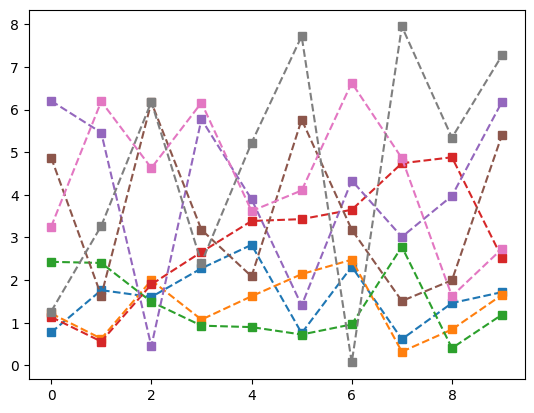

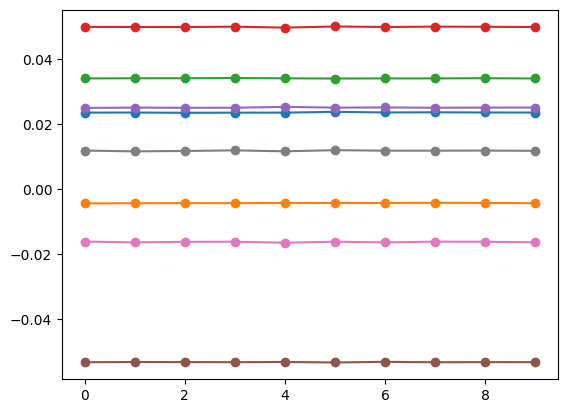

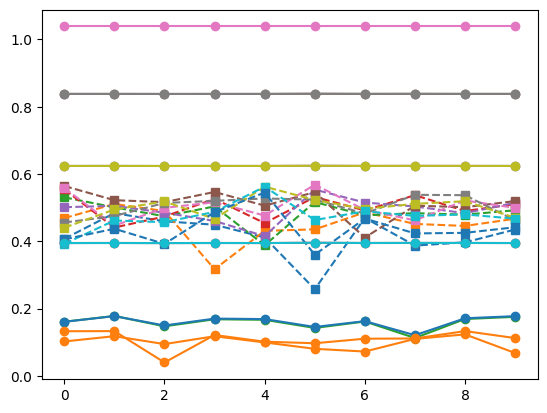

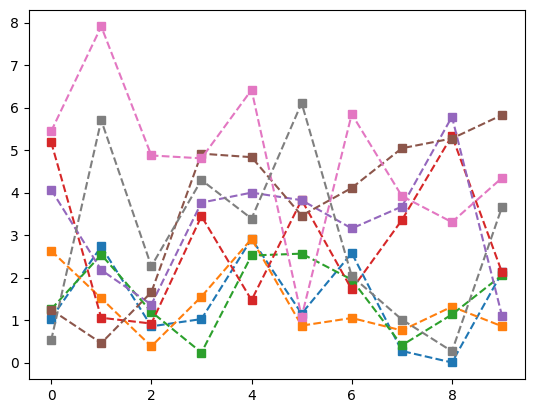

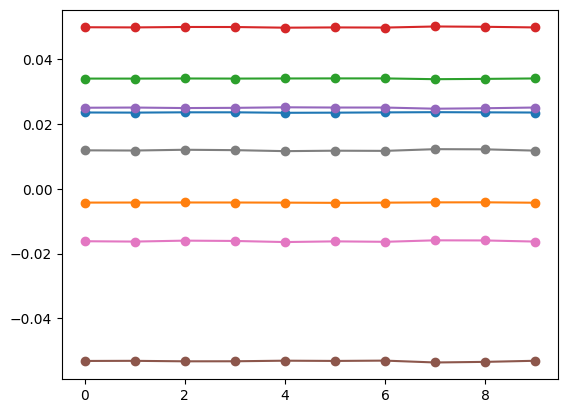

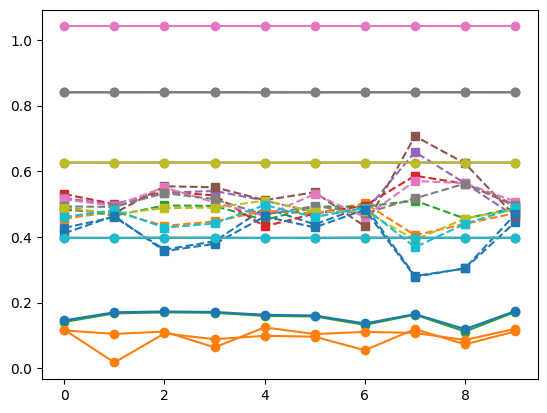

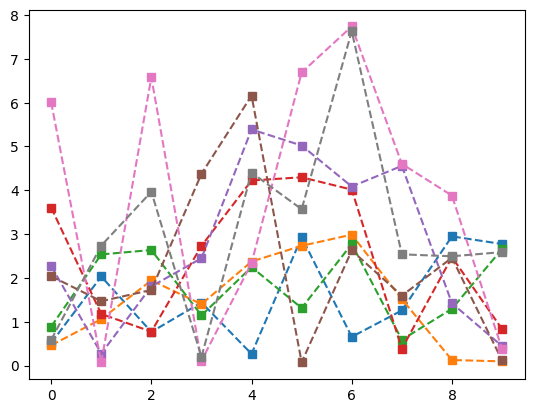

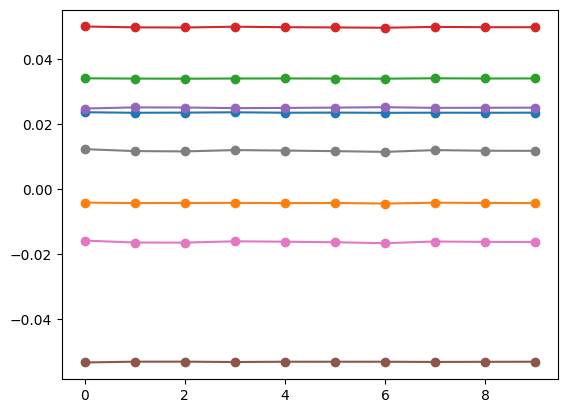

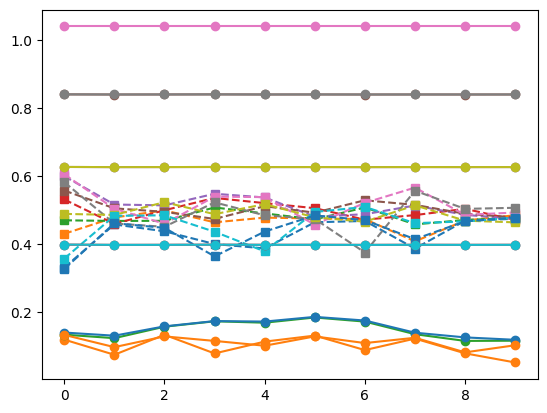

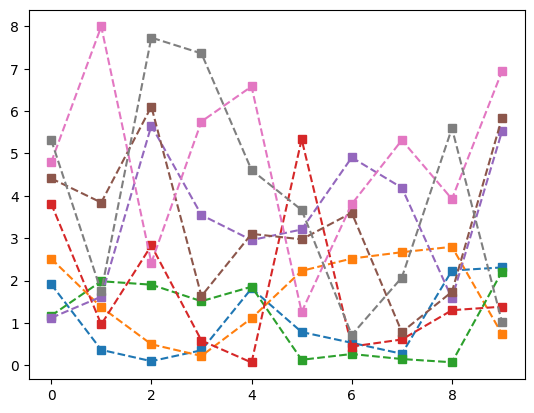

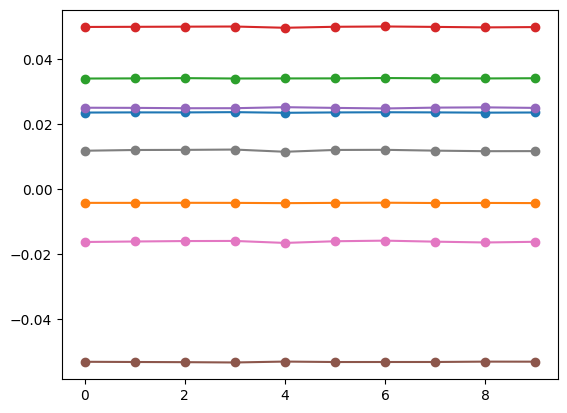

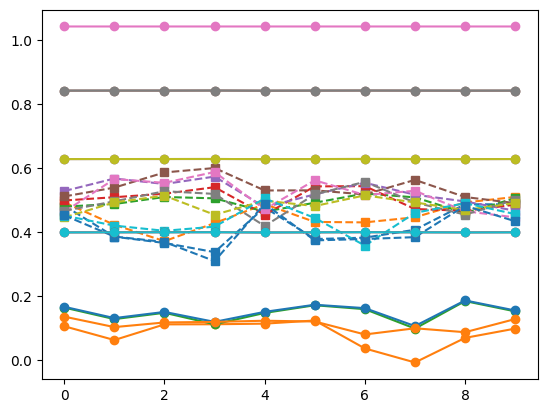

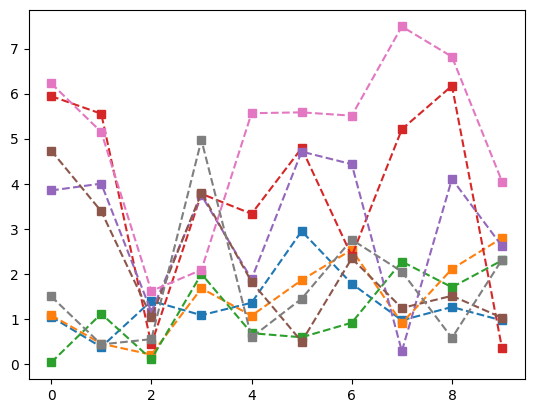

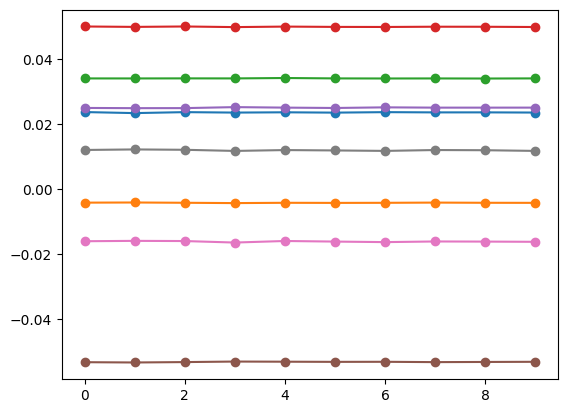

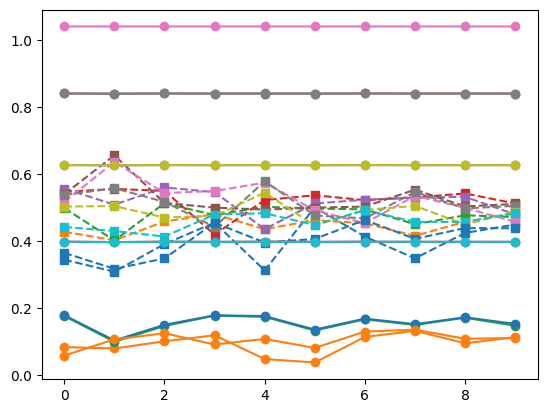

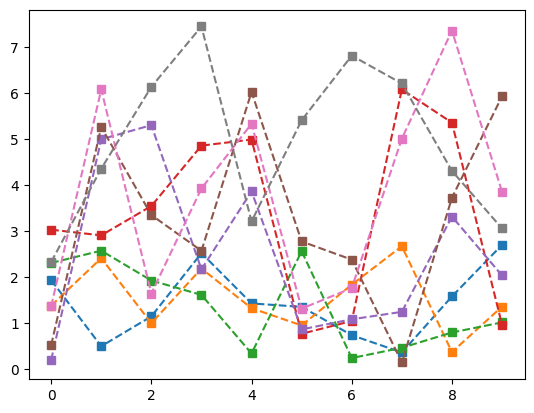

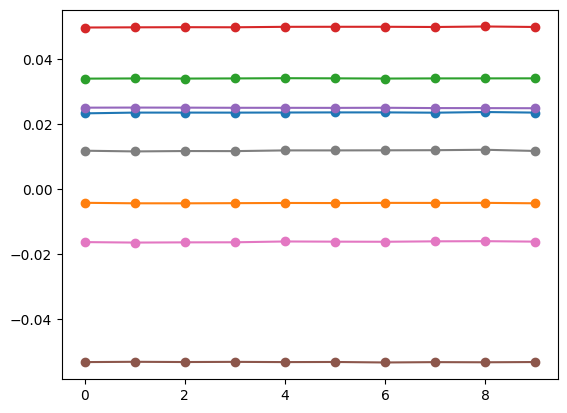

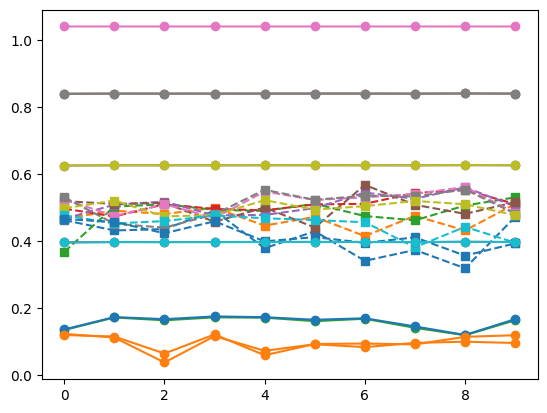

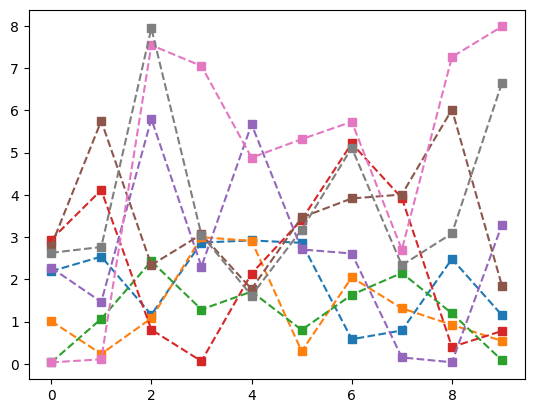

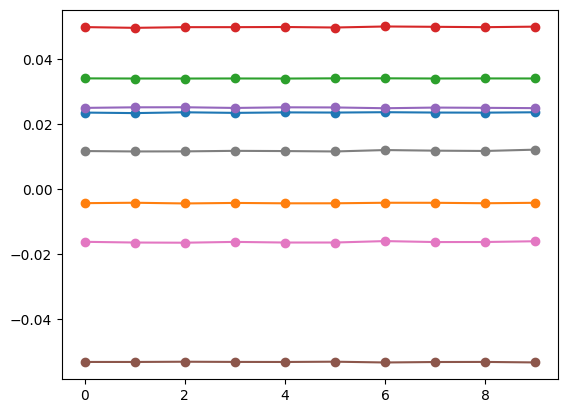

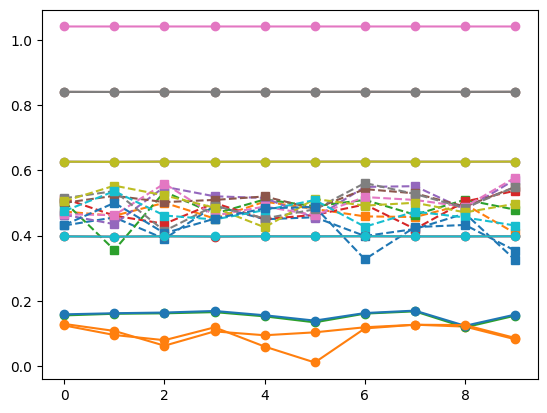

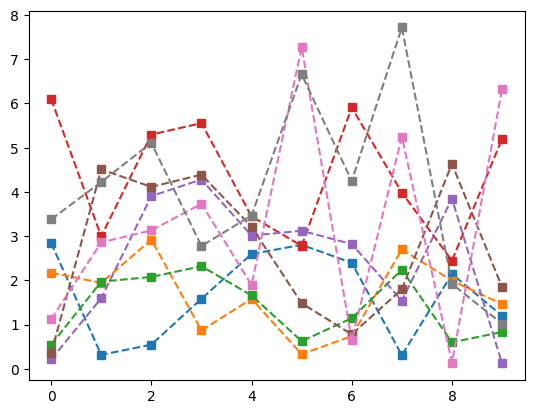

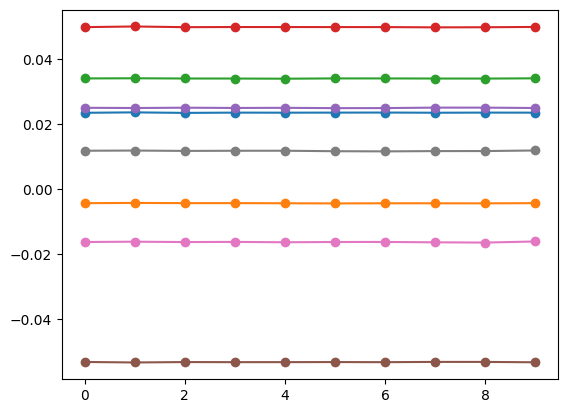

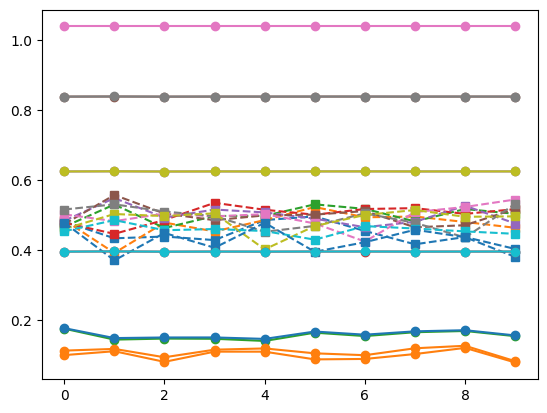

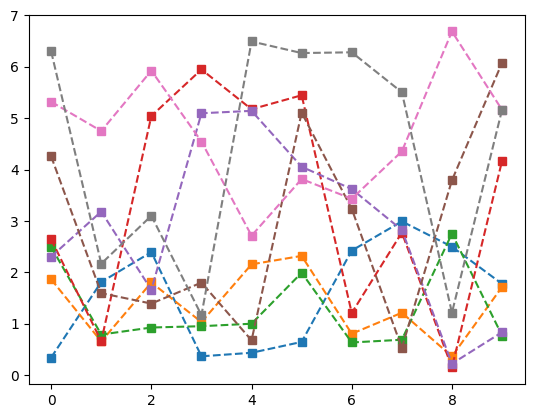

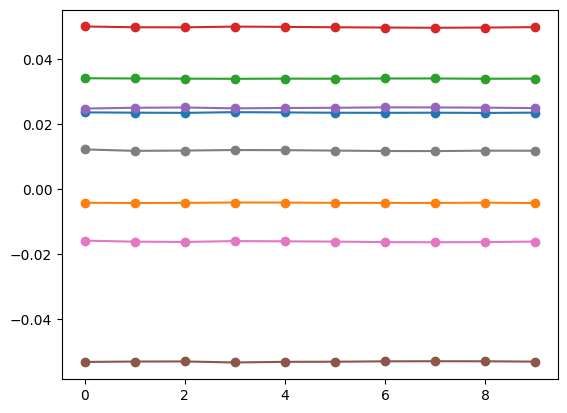

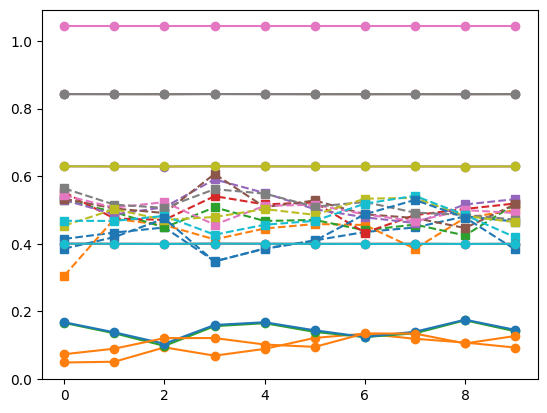

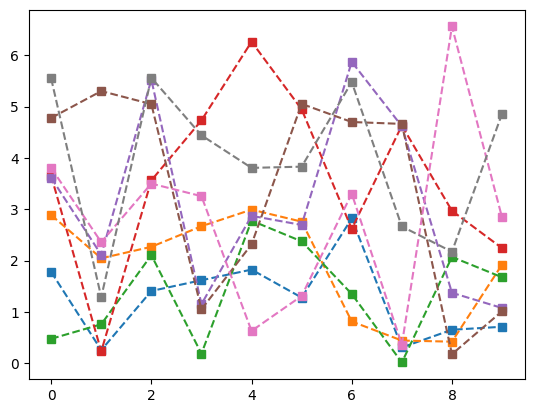

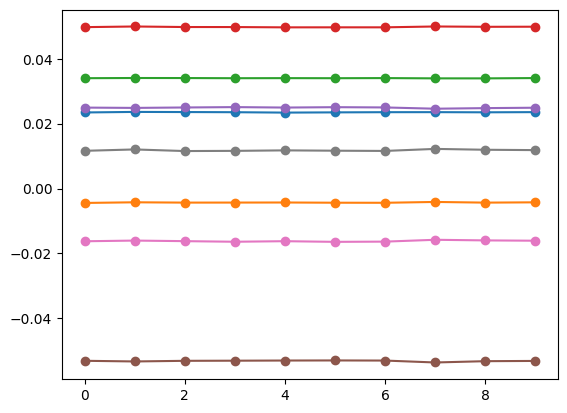

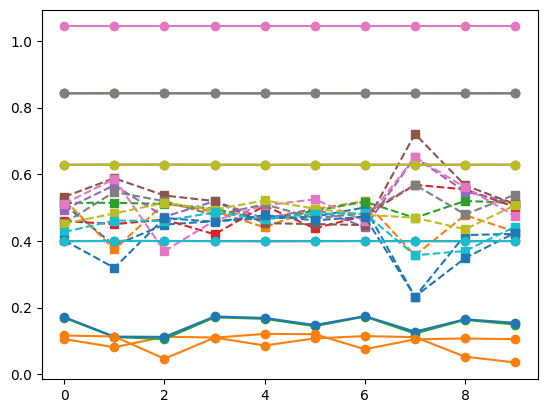

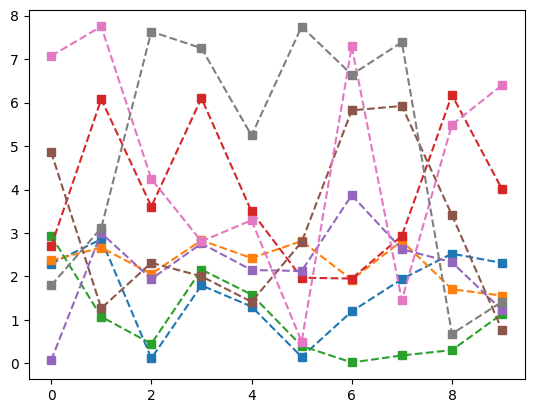

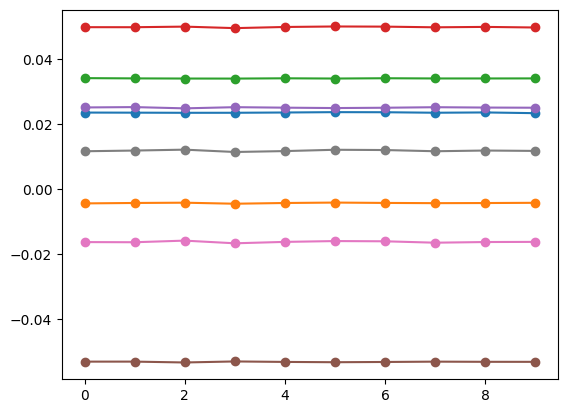

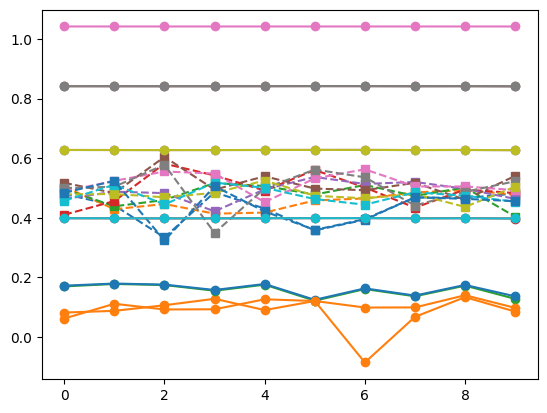

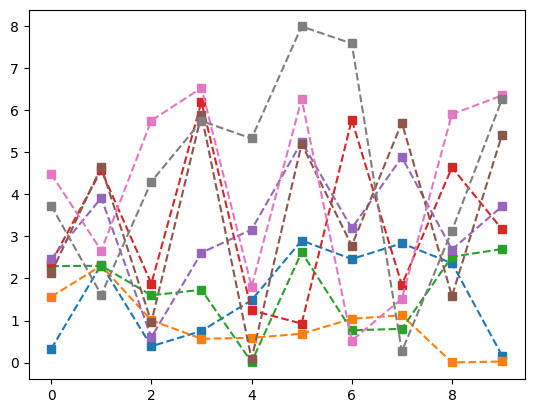

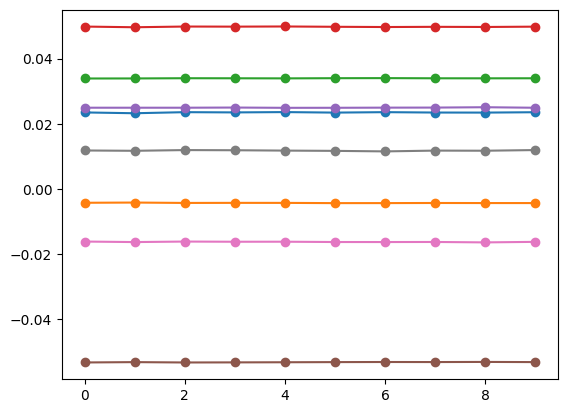

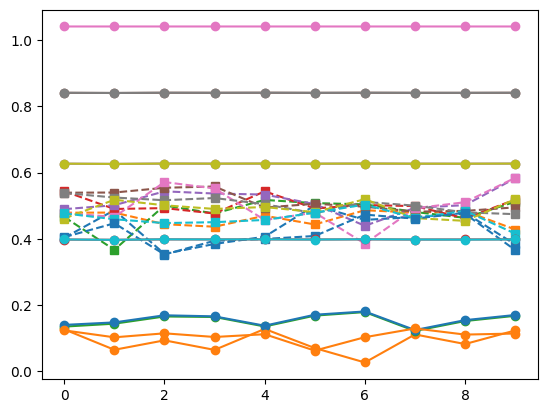

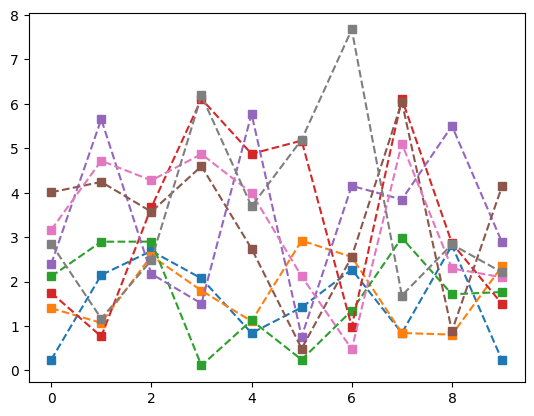

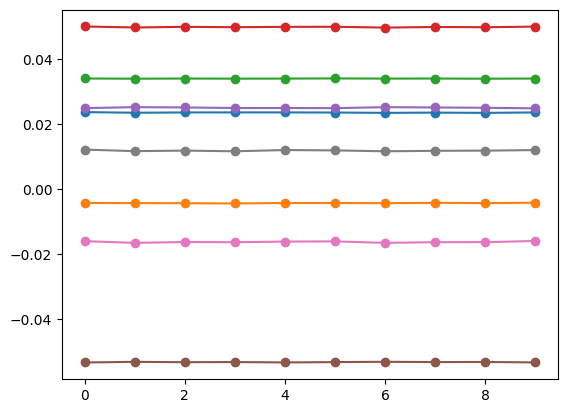

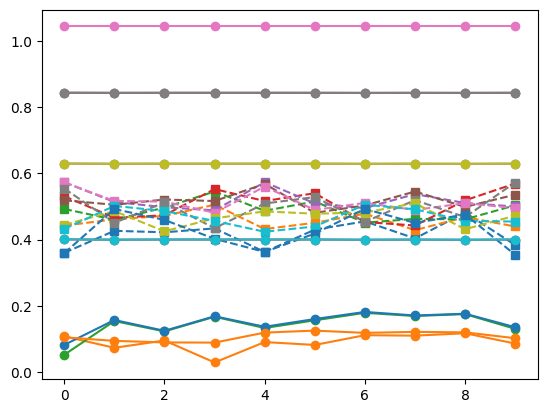

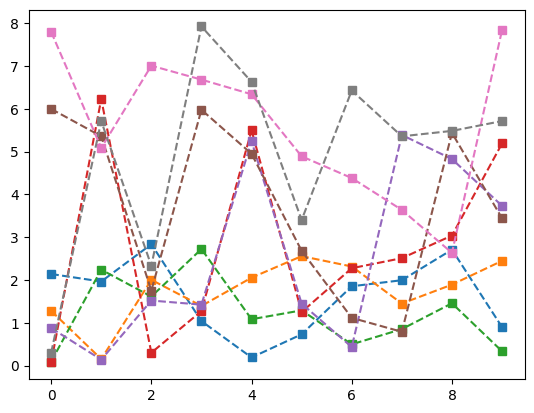

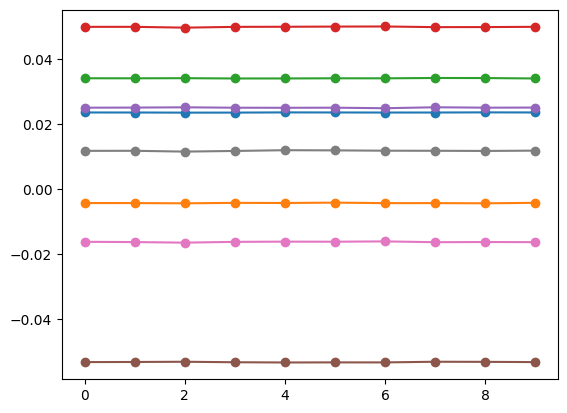

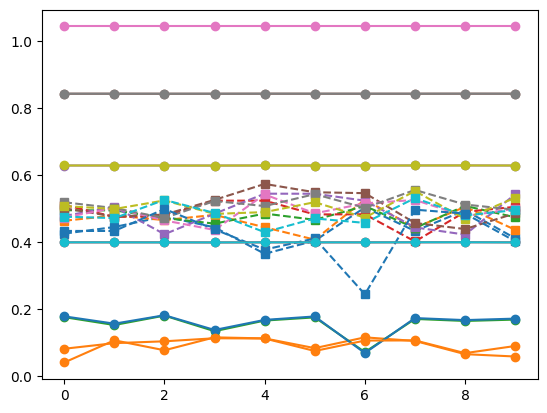

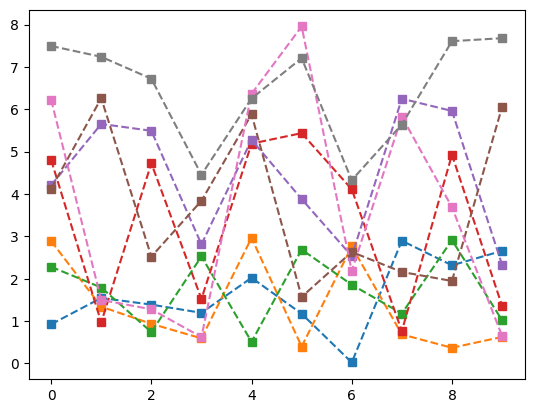

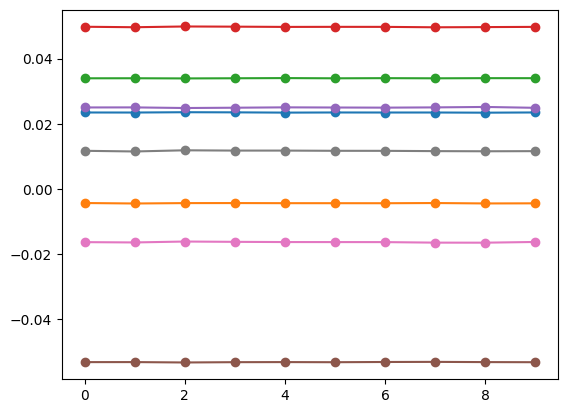

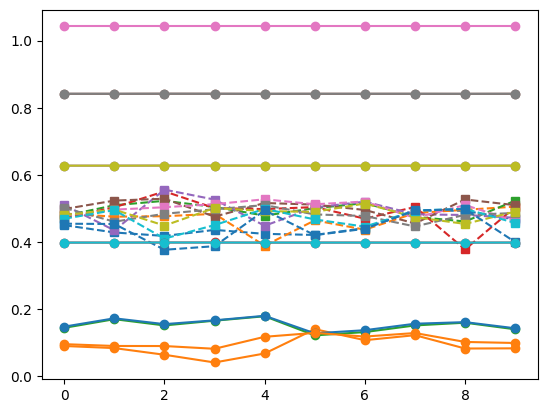

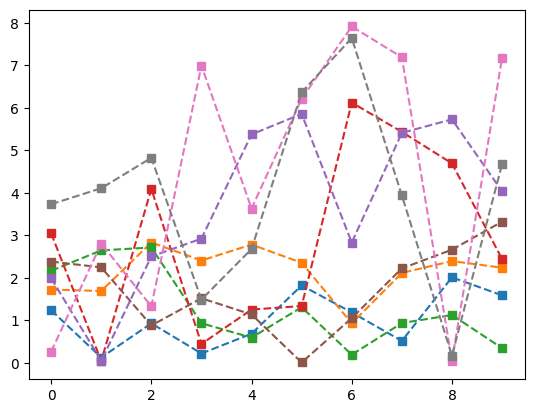

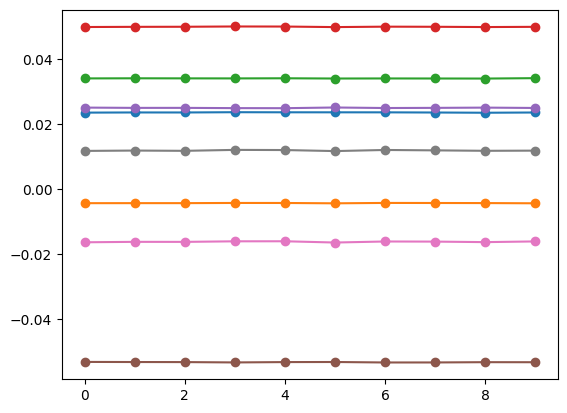

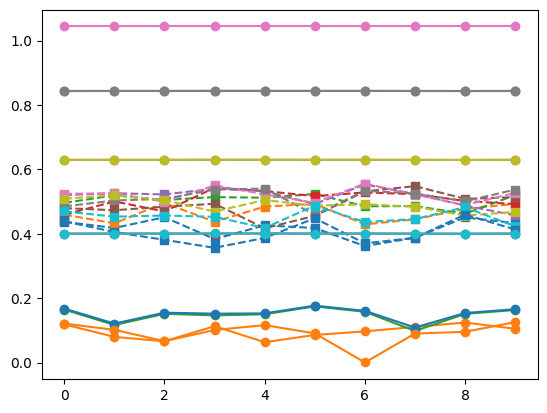

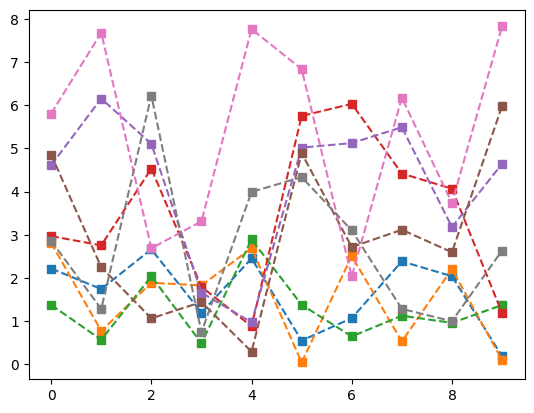

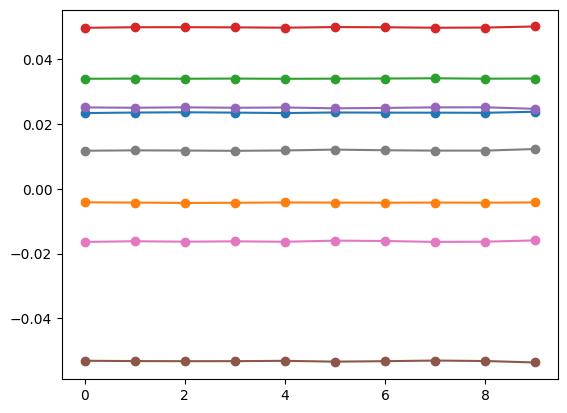

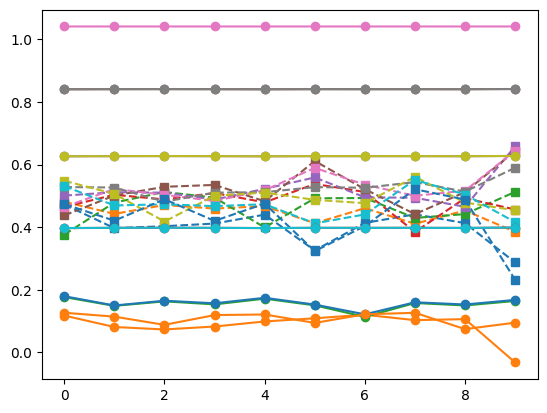

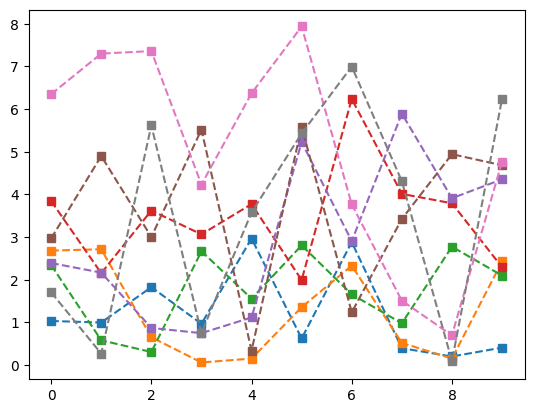

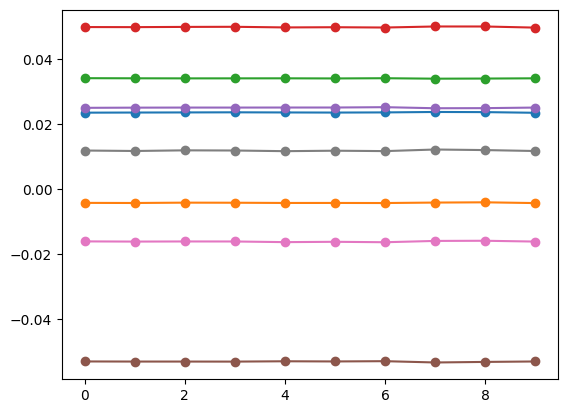

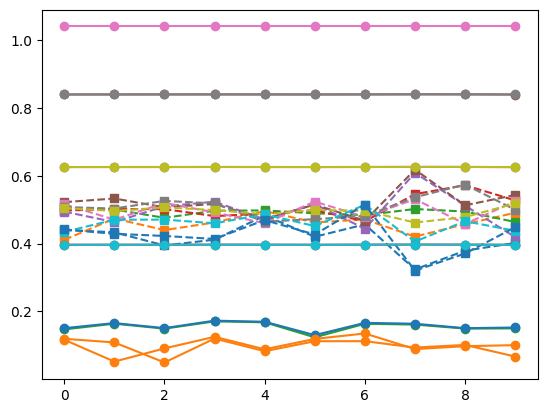

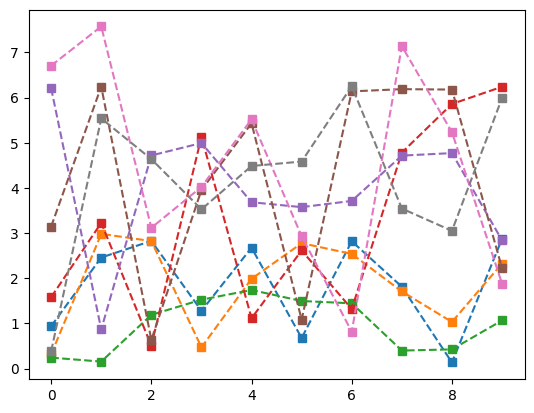

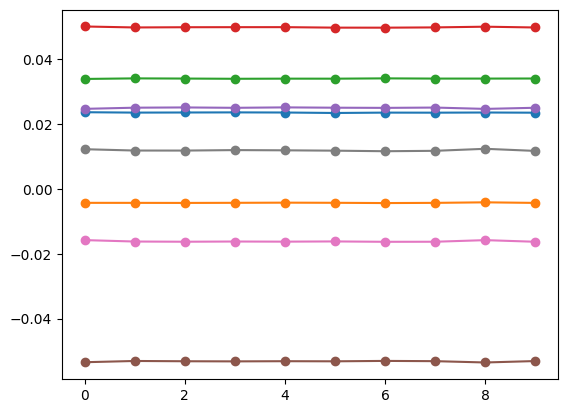

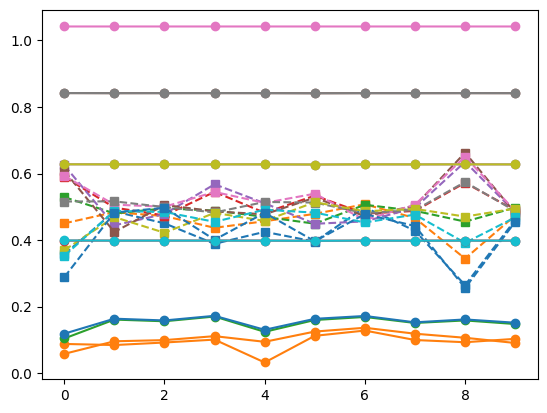

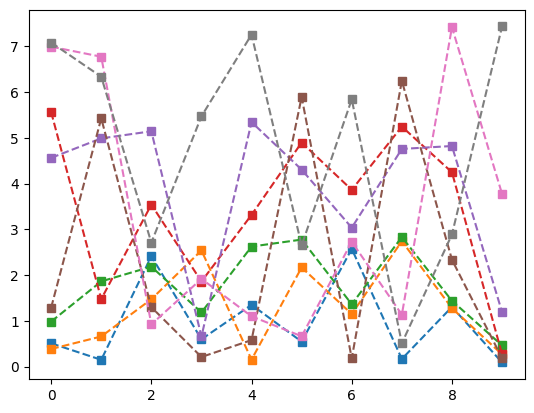

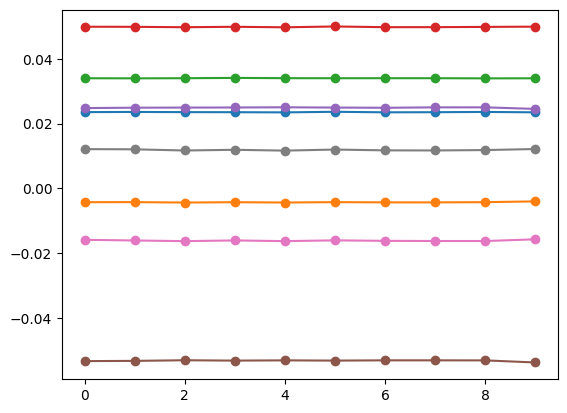

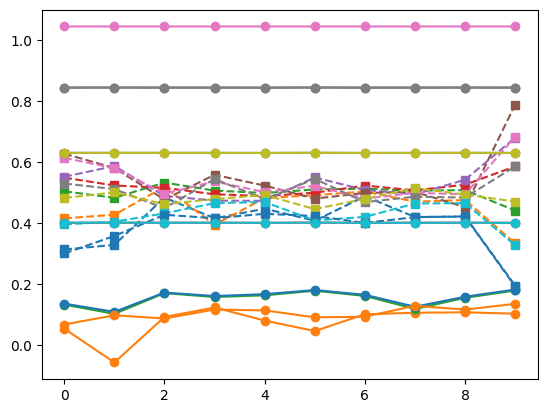

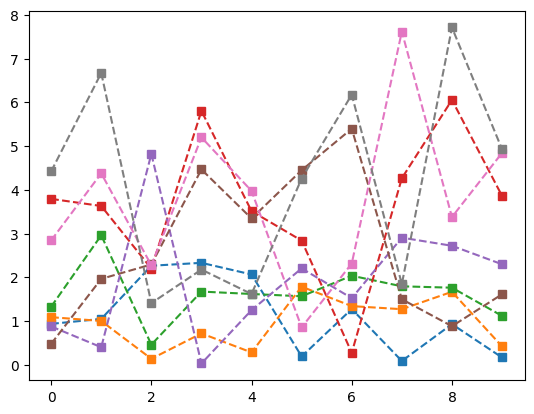

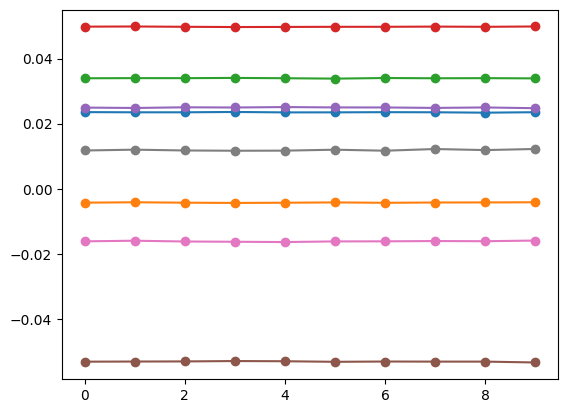

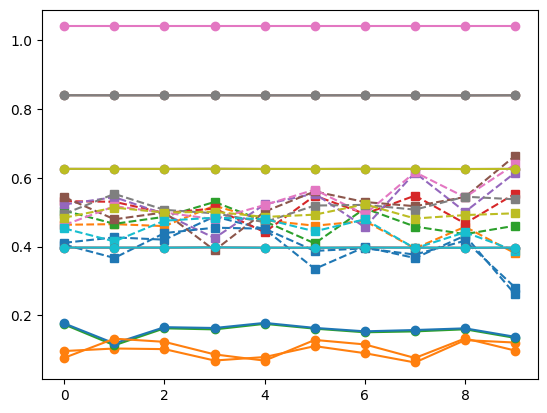

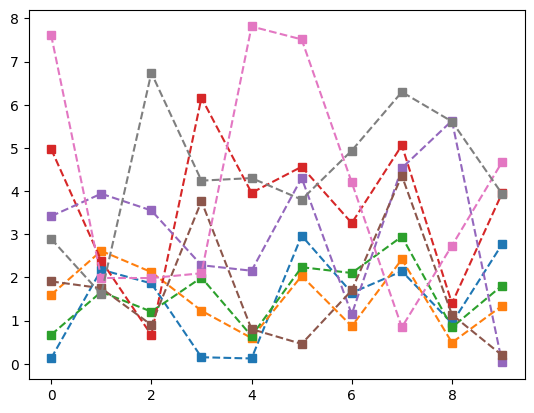

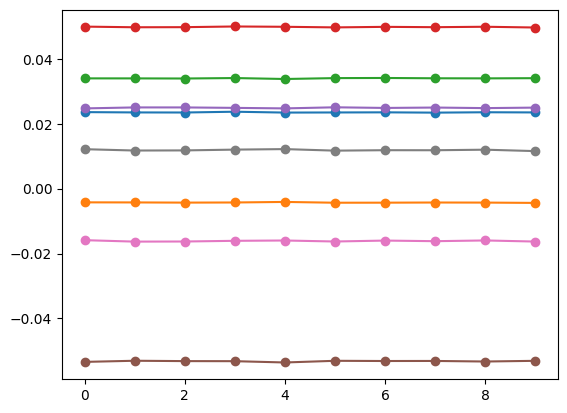

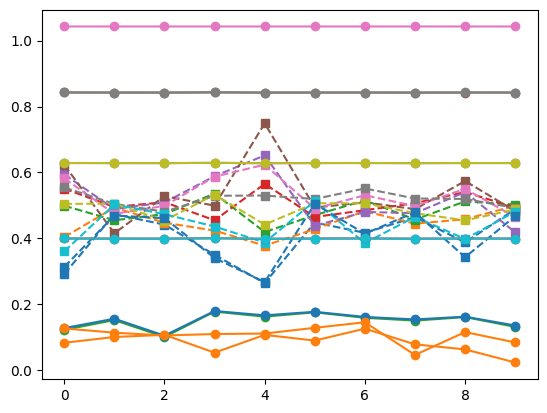

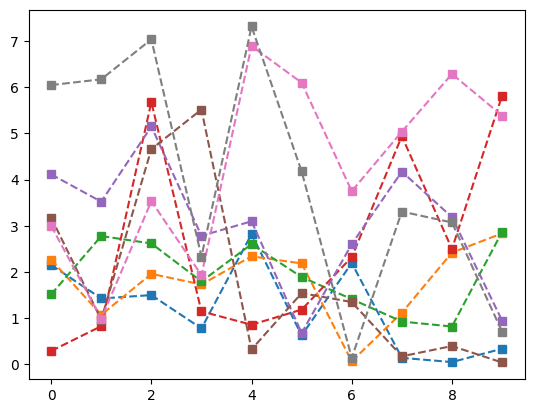

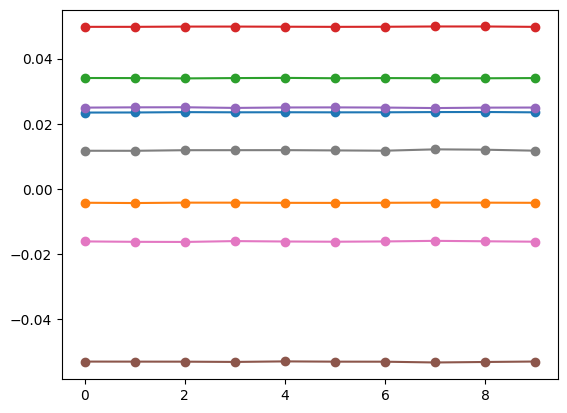

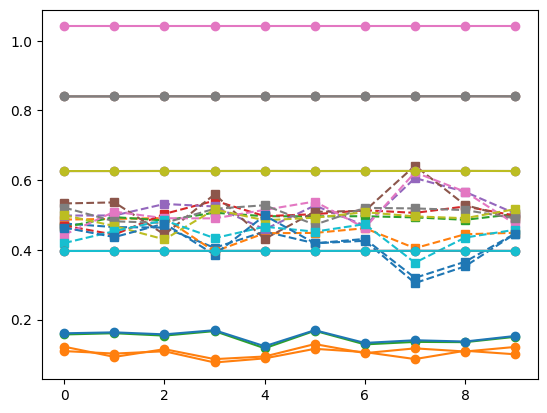

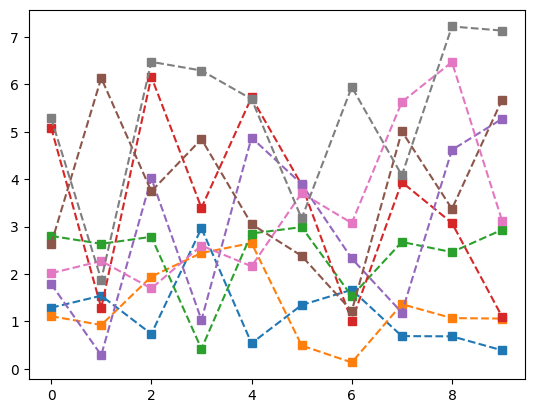

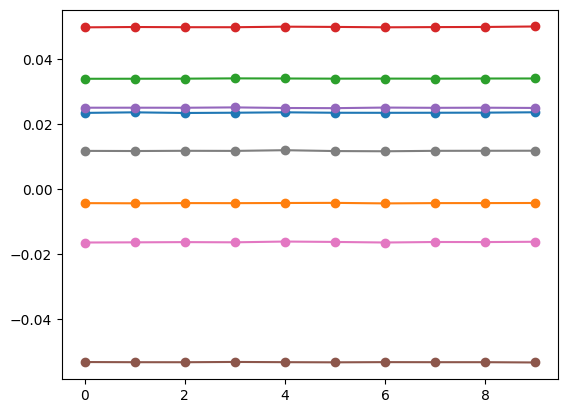

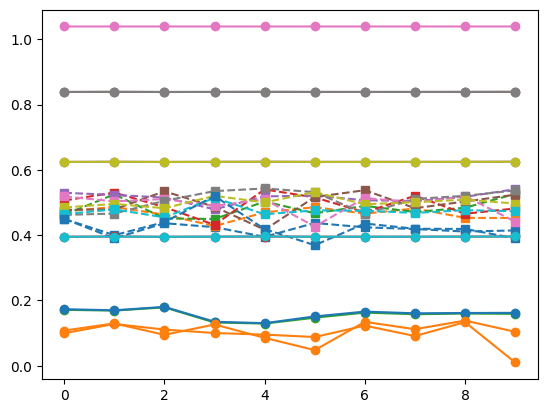

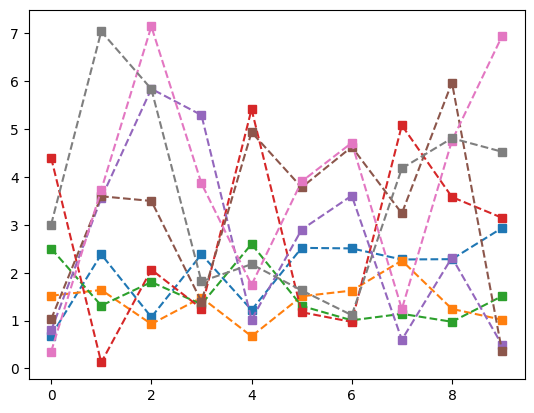

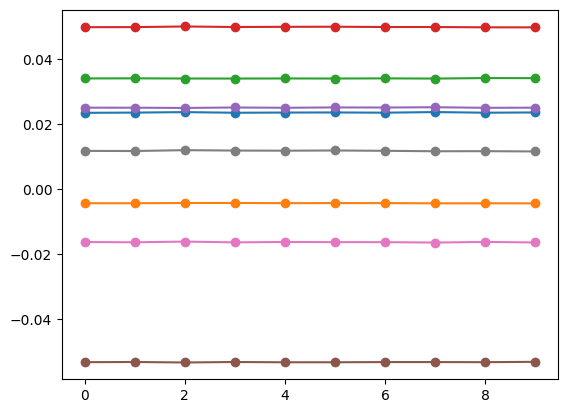

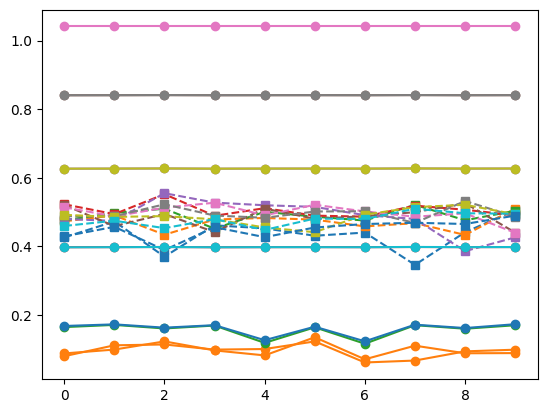

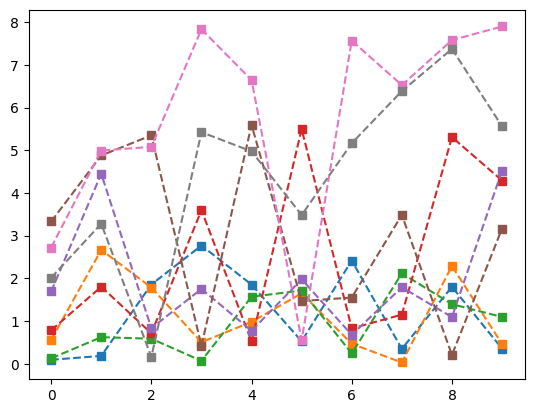

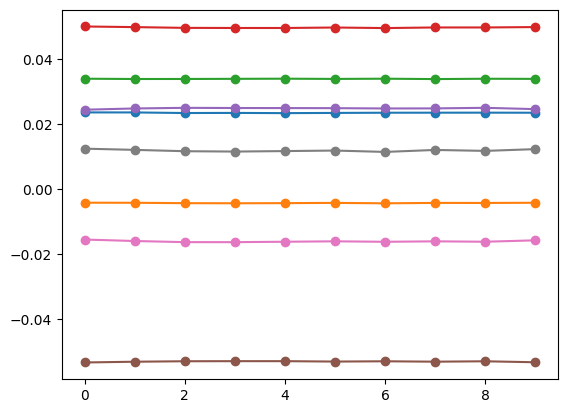

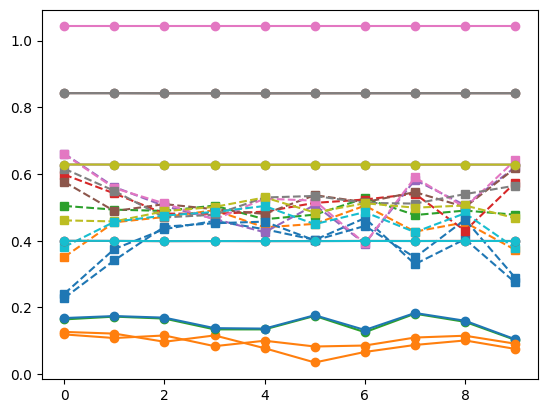

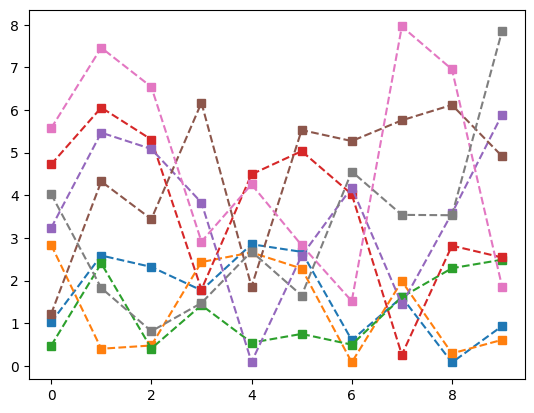

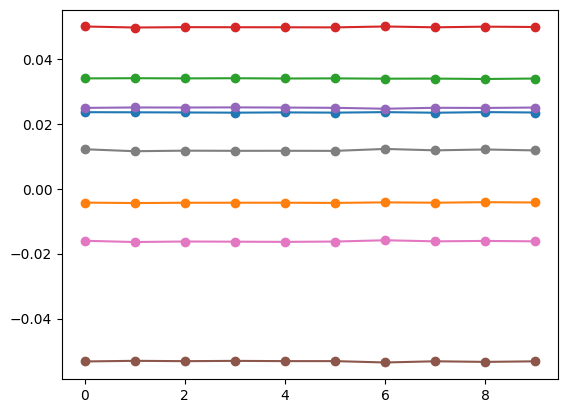

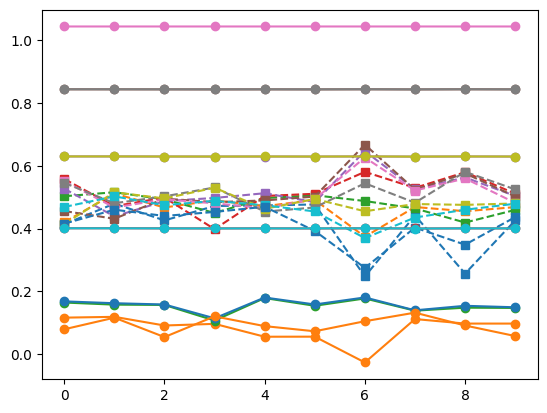

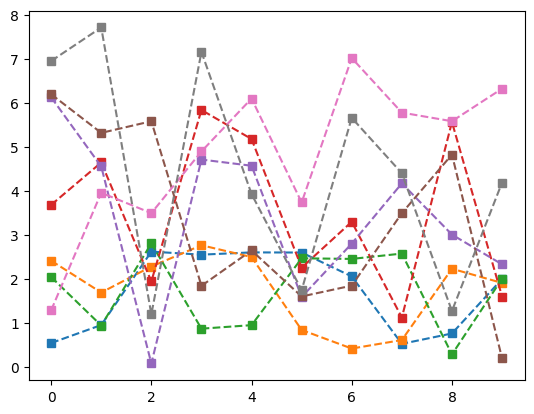

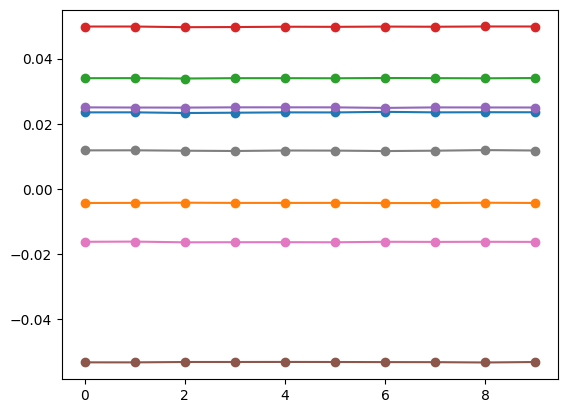

<Figure size 640x480 with 0 Axes>

In [9]:
num_epochs = 10
val_loss_min = 1
min_test_loss = 0.5

PATIENCE = 50
patience_counter = 0

for epoch in range(1, num_epochs + 1):

    # Training phase
    avg_train_loss, for_out, _, _, _ = run_one_epoch_inverse2("train", train_loader, frequencyCombPeaks, ofc_args, inverse_net, criterion, device, inv_optimizer)
    train_losses.append(avg_train_loss)

    # Validation phase
    avg_val_loss, _, _, _, _ = run_one_epoch_inverse2("val", val_loader, frequencyCombPeaks, ofc_args, inverse_net, criterion, device)
    val_losses.append(avg_val_loss)  # Append average validation loss for the epoch

    # Print training progress
    if(epoch%(num_epochs//10) == 0):
        print(f"Epoch: {epoch}/{num_epochs}... Training loss: {convert_to_real_loss(avg_train_loss, train_dataset.norm_scales):.6f} (dB/Hz)^2 ... Validation Loss: {convert_to_real_loss(avg_val_loss, train_dataset.norm_scales):.6f} (dB/Hz)^2")
        plot_training_progress(np.log10(train_losses), np.log10(val_losses), ylabel = "log10(Loss)")

    # Save model if validation loss has decreased
    if avg_val_loss <= val_loss_min:
        print(f'Validation loss decreased ({val_loss_min:.6f} --> {avg_val_loss:.6f}). Epoch: {epoch}. Saving model...')
        torch.save(inverse_net.state_dict(), inverse_net_name + "val_min.pth")
        val_loss_min = avg_val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print(f'Early stopping at epoch {epoch} with validation loss: {avg_val_loss:.6f}')
            break


In [ ]:
# Save model
torch.save({"model_state_dict" : inverse_net.state_dict(),
            "optimizer_state_dict": inv_optimizer.state_dict()}, inverse_net_path)

# Save training and validation losses for the inverse model
np.save(inv_train_losses_path, np.array(train_losses))
np.save(inv_val_losses_path, np.array(val_losses))

### <a id='toc2_4_1_'></a>[Test phase](#toc0_)

In [ ]:
# Test phase

perfect_flat_comb = torch.tensor([-90]*n_outputs).unsqueeze(0).to(device) #flat comb
#perfect_flat_comb = torch.tensor([-80,-85,-90,-95,-100,-105,-100,-95,-90,-85,-80]).unsqueeze(0).to(device) #alternating comb
#perfect_flat_comb = torch.tensor(0.5*np.arange(-5,6,1)**2, dtype=torch.float32).unsqueeze(0).to(device) #quadratic comb
#perfect_flat_comb = torch.tensor(200*np.exp(-0.01*np.arange(-5,6,1)**2), dtype=torch.float32).unsqueeze(0).to(device) #gaussian comb 
#perfect_flat_comb = torch.tensor(-60*np.exp(-0.01*np.arange(-5,6,1)**2), dtype=torch.float32).unsqueeze(0).to(device) #gaussian comb negative
#perfect_flat_comb = torch.tensor(-np.abs(8*np.arange(-5,6,1)), dtype=torch.float32).unsqueeze(0).to(device) #hate comb
#perfect_flat_comb = torch.tensor(3.6*np.arange(-5,6,1), dtype=torch.float32).unsqueeze(0).to(device) # linear comb
#perfect_flat_comb = -2.5*torch.tensor([-80,-85,-80,-85,-80,-85,-80,-85,-80,-85,-80]).unsqueeze(0).to(device) #alternating comb
#perfect_flat_comb[0,5]= -115 #hole


# Test FlatComb
perfect_flat_comb = perfect_flat_comb - torch.mean(perfect_flat_comb, dtype = torch.float32) * train_loader.dataset.zero_mean
perfect_flat_comb = train_dataset.normalize(perfect_flat_comb)

perfect_flat_comb_inv_output = inverse_net(perfect_flat_comb)

inverse_peaks = all_in_a_single_one_function(perfect_flat_comb_inv_output, ofc_args).to(device)
inverse_peaks = inverse_peaks - torch.mean(inverse_peaks, dtype = torch.float32) * train_loader.dataset.zero_mean
inverse_peaks = train_dataset.normalize(inverse_peaks)

inv_loss = criterion(perfect_flat_comb, inverse_peaks).item()
inv_loss = convert_to_real_loss(inv_loss, train_dataset.norm_scales).item()

perfect_flat_comb_denorm = train_dataset.denormalize(perfect_flat_comb).cpu().detach().numpy().squeeze()
inverse_peaks_denorm = train_dataset.denormalize(inverse_peaks).cpu().detach().numpy().squeeze()

# Plot the Comparison
title = "Testing the inverse model with a perfect flat comb as input"
title = ''
figname = 'figures/fig_inverse_flat_comb'
figname = 'figures/fig_inverse_hat_comb'
figname = 'figures/fig_inverse_hole_comb'
figname = 'figures/inverseNet_sample3'
figname = 'figures/fig_inverse_flat_comb'
figname = 'figures/fig_inverse_linear_comb'
figname = 'figures/fig_inverse_gaussian_comb'


#plot_comparison_style(perfect_flat_comb_denorm, inverse_peaks_denorm, freqs_peaks_GHz, inv_loss, figname, title, show_max_min=True, ylim = (-3,3))
plot_comparison_style(perfect_flat_comb_denorm, inverse_peaks_denorm, freqs_peaks_GHz, inv_loss, figname, title, show_max_min=False)

In [ ]:

# Test phase
avg_test_loss, inv_for_outputs, inverse_outputs, targets, inputs = run_one_epoch_inverse("test", test_loader, forward_net, inverse_net, criterion, device)
print(f"Test Loss: {convert_to_real_loss(avg_test_loss, train_dataset.norm_scales):.6f} (dB/Hz)^2")

# Loop over the first n examples
for i in range(min(10, targets.shape[0])):

    inverse_peaks = torch.tensor(frequencyCombPeaks(inverse_outputs[i].cpu().detach().numpy(), ofc_args), dtype=torch.float32).to(device)
    inverse_peaks = inverse_peaks - torch.mean(inverse_peaks)
    inverse_peaks = train_dataset.normalize(inverse_peaks)

    # Denormalize
    targets_denorm = train_dataset.denormalize(targets[i])
    inverse_peaks_denorm = train_dataset.denormalize(inverse_peaks)

    inverse_loss = criterion(inverse_peaks_denorm, targets_denorm).item()

    targets_denorm = targets_denorm.cpu().detach().numpy().squeeze()
    inverse_peaks_denorm = inverse_peaks_denorm.cpu().detach().numpy().squeeze()
    figname = f'inverseNet_sample{i+1}'
    title = f"Sample {i+1}"
    title = ''
    plot_comparison_style(targets_denorm, inverse_peaks_denorm, freqs_peaks_GHz, inverse_loss, figname, title)

# <a id='toc3_'></a>[Bayesian Optimization](#toc0_)

In [ ]:
from bayes_opt import BayesianOptimization
import pickle

#https://github.com/jeffheaton/app_deep_learning/blob/main/t81_558_class_08_4_bayesian_hyperparameter_opt.ipynb

In [ ]:
n_inputs = 8
n_outputs = 11

In [ ]:
N = 783200 # Quantity of net parameters
n_layers = 6
#n_layers should be > 1
a = (n_layers-1)
b = (n_layers+n_inputs+n_outputs)
c = (n_outputs-N)
n_neurons_per_layer = round((-b + np.sqrt(b**2 - 4*a*c))/(2*a))
n_neurons_per_layer

## <a id='toc3_1_'></a>[Forward Network](#toc0_)

In [ ]:
PATIENCE = 10
NUM_EPOCHS = 100
epoch_min = 15

n_inputs = train_dataset.input_tensors.shape[1]
n_outputs = train_dataset.output_tensors.shape[1]

def evaluate_forward_network(learning_rate:float = 0.001 , n_layers:int = 3, n_neurons_per_layer:int = 300 , batch_size_p:float = 8):

    n_neurons_per_layer = round(n_neurons_per_layer)
    n_layers = round(n_layers)
    batch_size = round(2**batch_size_p)
    architecture = [n_inputs] + [n_neurons_per_layer]*n_layers + [n_outputs]
    
    model = FrequencyCombNet(architecture).to(device)
    criterion = nn.MSELoss() # Mean Squared Error
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate) # lr - learning rate

    train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle=True)

    val_loss_min = 1
    patience_counter = 0

    for epoch in range(1, NUM_EPOCHS + 1):

        # Training phase
        run_one_epoch_forward("train", train_loader, model, criterion, device, optimizer)
        train_losses.append(avg_train_loss) #Epoch training losses for plotting

        # Validation phase
        avg_val_loss, _, _ = run_one_epoch_forward("val", val_loader, model, criterion, device)
        val_losses.append(avg_val_loss) # Append average validation loss for the epoch

        # Patience counter
        if avg_val_loss <= val_loss_min:
            val_loss_min = avg_val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= PATIENCE and epoch > epoch_min:
            break

    print(inverse_architecture, f"n_epochs: {epoch}")

    return -val_loss_min

In [ ]:
# Bounded region of parameter space
pbounds = {'learning_rate': (0.0, 0.1),
           'n_layers': (1, 7),
           'n_neurons_per_layer': (128, 512),
           'batch_size_p': (6, 10)
           }

bayesian_optimizer_forward = BayesianOptimization(
    f=evaluate_forward_network,
    pbounds=pbounds,
    verbose=2,
    random_state=1,
)

In [ ]:
bayesian_optimizer_forward.maximize(init_points=10, n_iter=20)

In [ ]:
best_case = bayesian_optimizer_forward.max["params"]
best_case

In [ ]:
print("Batch_size: ", round(2**best_case["batch_size_p"]))
print("Learning Rate: ", best_case["learning_rate"])
print("Architecture: ", [n_outputs] + [round(best_case["n_neurons_per_layer"])]*round(best_case["n_layers"]) + [n_inputs])

## <a id='toc3_2_'></a>[Inverse Network](#toc0_)

In [ ]:
PATIENCE = 10
NUM_EPOCHS = 100
epoch_min = 15

n_inputs = train_dataset.input_tensors.shape[1]
n_outputs = train_dataset.output_tensors.shape[1]

forward_net_name = 'model_8_243_243_243_243_243_243_11_mzm_mzm_pm_300k_samples_batch_size_1024'
forward_net_path = "saved_data/models/" + forward_net_name + ".pth"
model_dict_data = torch.load(forward_net_path, map_location=torch.device(device))
forward_architecture = get_architecture(model_dict_data)
forward_net = FrequencyCombNet(forward_architecture).to(device)
forward_net.load_state_dict(model_dict_data["model_state_dict"])  # Load pre-trained weights
forward_net.eval()  # Set model to evaluation mode

for p in forward_net.parameters():
    p.requires_grad = False  # Freeze the weights and biases

def evaluate_inverse_network(learning_rate:float = 0.001 , n_layers:int = 3, n_neurons_per_layer:int = 300 , batch_size_p:float = 8):

    n_neurons_per_layer = round(n_neurons_per_layer)
    n_layers = round(n_layers)
    batch_size = round(2**batch_size_p)

    # Create an inverse model
    inverse_architecture = [n_outputs] + [n_neurons_per_layer]*n_layers + [n_inputs]
    inverse_net = FrequencyCombNet(inverse_architecture).to(device)
    
    # Loss Function
    criterion = nn.MSELoss() # Mean Squared Error

    # Optimizer
    inv_optimizer = torch.optim.Adam(inverse_net.parameters(), lr = learning_rate) # lr - learning rate

    train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle=True)

    val_loss_min = 1
    patience_counter = 0

    for epoch in range(1, NUM_EPOCHS + 1):
            
        # Training phase
        run_one_epoch_inverse("train", train_loader, forward_net, inverse_net, criterion, device, inv_optimizer)

        # Validation phase
        avg_val_loss, _, _, _, _ = run_one_epoch_inverse("val", val_loader, forward_net, inverse_net, criterion, device)
        
        # Patience counter
        if avg_val_loss <= val_loss_min:
            val_loss_min = avg_val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= PATIENCE and epoch > epoch_min:
            break

    print(inverse_architecture, f"n_epochs: {epoch}")

    return -avg_val_loss

def evaluate_inverse_network2(learning_rate:float = 0.0001 , n_layers:int = 6, batch_size_p:float = 6.5):

    N = 600000 # Quantity of net parameters

    #n_layers should be > 1
    a = (n_layers-1)
    b = (n_layers+n_inputs+n_outputs)
    c = (n_outputs-N)
    n_neurons_per_layer = round((-b + np.sqrt(b**2 - 4*a*c))/(2*a))
    
    n_layers = round(n_layers)
    batch_size = round(2**batch_size_p)

    # Create an inverse model
    inverse_architecture = [n_outputs] + [n_neurons_per_layer]*n_layers + [n_inputs]
    inverse_net = FrequencyCombNet(inverse_architecture).to(device)
    
    # Loss Function
    criterion = nn.MSELoss() # Mean Squared Error

    # Optimizer
    inv_optimizer = torch.optim.Adam(inverse_net.parameters(), lr = learning_rate) # lr - learning rate

    train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle=True)

    val_loss_min = 1
    patience_counter = 0

    for epoch in range(1, NUM_EPOCHS + 1):
            
        # Training phase
        run_one_epoch_inverse("train", train_loader, forward_net, inverse_net, criterion, device, inv_optimizer)

        # Validation phase
        avg_val_loss, _, _, _, _ = run_one_epoch_inverse("val", val_loader, forward_net, inverse_net, criterion, device)
        
        # Patience counter
        if avg_val_loss <= val_loss_min:
            val_loss_min = avg_val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= PATIENCE and epoch > epoch_min:
            break

    print(inverse_architecture, f"n_epochs: {epoch}")

    return -avg_val_loss



In [ ]:
# Bounded region of parameter space
pbounds = {'learning_rate': (0.0, 0.0001),
           'n_layers': (3, 6),
           'n_neurons_per_layer': (128, 512),
           'batch_size_p': (6, 10)
           }

bayesian_optimizer_inverse = BayesianOptimization(
    f=evaluate_inverse_network,
    pbounds=pbounds,
    verbose=2,
    random_state=1,
)


#with open('bayes_opt_state_inv.pkl', 'rb') as f:
#    bayesian_optimizer_inverse = pickle.load(f)

In [ ]:
bayesian_optimizer_inverse.maximize(init_points=0, n_iter=20)

In [ ]:
# Bounded region of parameter space
pbounds2 = {'learning_rate': (0.0, 0.0001),
           'n_layers': (3, 6),
           'batch_size_p': (6, 10)
           }

bayesian_optimizer_inverse = BayesianOptimization(
    f=evaluate_inverse_network2,
    pbounds=pbounds2,
    verbose=2,
    random_state=1,
)

In [ ]:
bayesian_optimizer_inverse.maximize(init_points=10, n_iter=20)


In [ ]:
import pandas as pd

bayesian_optimizer_inverse_res = [{"target": i["target"], **i["params"]} for i in bayesian_optimizer_inverse.res]
bayesian_optimizer_inverse_res = [{"target": i["target"], "batch_size": round(2**i["batch_size_p"]), "learning_rate": i["learning_rate"], "n_layers": round(i["n_layers"]), "n_neurons_per_layer": round(i["n_neurons_per_layer"])} for i in bayesian_optimizer_inverse_res]

# Convert the optimization history to a DataFrame
optimization_history = pd.DataFrame(bayesian_optimizer_inverse_res).sort_values(by='target', ascending=False)
display(optimization_history.head(30))

In [ ]:
#save optimizer state checkout to load and continue the optimization later
with open('bayes_opt_state_inv2.pkl', 'wb') as f:
    pickle.dump(bayesian_optimizer_inverse, f)

In [ ]:
best_case = bayesian_optimizer_inverse.max["params"]
print("Batch_size: ", round(2**best_case["batch_size_p"]))
print("Learning Rate: ", best_case["learning_rate"])
print("Architecture: ", [n_outputs] + [round(best_case["n_neurons_per_layer"])]*round(best_case["n_layers"]) + [n_inputs])

# <a id='toc4_'></a>[Other Auxiliar Figures](#toc0_)

In [ ]:
#plotting the first four Bessel funcions
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import jn


with plt.style.context(['science', 'ieee', "grid", 'no-latex']):
    fig, ax = plt.subplots(figsize=(3*0.8,2.4*0.8), dpi = 300)
    x = np.linspace(0, 20, 100)
    for n in range(4):
        plt.plot(x, jn(n, x), label=fr"$J_{n}(x)$", color = f"C{n}",lw =1.2)

    ax.legend()
    ax.autoscale(tight=True)
    ax.set_xlabel("$x$")
    ax.set_ylabel(r"$J_n(x)$")
    ax.set_xlim(0, 17)
    ax.set_ylim(-0.5,1.3)
    ax.set_yticks(np.arange(-0.4,1.4,0.4))
    plt.subplots_adjust(left=0.15, right=0.95, top=0.9, bottom=0.1)
    fig.savefig("bessel_Jn", dpi=300)
    plt.show()
    plt.close()

In [ ]:
#plotting the power spectral density of a optical frequency comb generated using PM modulation

V1 = 10
Phase1 = 0
u1 = V1 * np.cos(2 * π * ofc_args.Rs * ofc_args.t + Phase1)
frequency_comb = pm(1, u1, 5)
#'''
params = [2,2,2,2,2,4,3,3]
params = [2,2,2,4,3,4,3,3]
V1, V2, V3, Phase1, Phase2, Phase3, Vb1, Vb2 = params

u1 = V1 * np.cos(2 * π * ofc_args.Rs * ofc_args.t + Phase1)
u2 = V2 * np.cos(2 * π * ofc_args.Rs * ofc_args.t + Phase2)
u3 = V3 * np.cos(2 * π * ofc_args.Rs * ofc_args.t + Phase3)

frequency_comb = ofc_args.P
frequency_comb =  pm(frequency_comb, u3, ofc_args.Vpi)
frequency_comb = mzm(frequency_comb, u1, ofc_args.Vpi, Vb1)
frequency_comb = mzm(frequency_comb, u2, ofc_args.Vpi, Vb2)
#'''

Pxx, freqs = get_psd_ByFFT(frequency_comb, ofc_args.Fa, ofc_args.NFFT) # Get the power spectrum of the frequency comb signal
log_Pxx = 10*np.log10(Pxx) # Convert the power spectrum to dB
indx = get_indx_peaks(log_Pxx, ofc_args.NFFT/ofc_args.SpS, ofc_args.n_peaks) 
peaks = log_Pxx[indx].tolist()
   
with plt.style.context(['science', 'ieee', "grid", 'no-latex']):
    fig, ax = plt.subplots(figsize = (3*0.8,2.4*0.8), dpi = 300)
    ax.plot(freqs/ofc_args.Rs,log_Pxx,"g-", label='Optical Frequency Comb',lw = 1.3)
    ax.plot(freqs[indx]/ofc_args.Rs,peaks,"ko", label='Peaks', markersize=4)
    ax.autoscale(tight=True)
    
    ax.set_xlim(-10.9, 10.9)
    ax.set_ylim(-126, -82)
    #ax.set_ylim(-300, -82)
    ax.set_xlabel(r"$Frequência\; Básica\; (em\; unidades\; de\; f_m)$")
    ax.set_ylabel(r"$PSD\; (dB/Hz)$")

    #ax.yaxis.tick_right()
    #ax.yaxis.set_label_position("right")

    plt.subplots_adjust(left=0.15, right=0.95, top=0.9, bottom=0.1)

    #fig.savefig("ofc_pm_example", dpi=300)
    fig.savefig("ofc_peaks_example", dpi=300)
    plt.show()
    plt.close()
    

In [ ]:
Vpi = 2
Vdc = -2

Vmax = 4
Vmin = -4
V = np.linspace(Vmin, Vmax, 100)

with plt.style.context(['science', 'ieee', "grid", 'no-latex']):
    fig, ax = plt.subplots(figsize=(5*0.8,2.4*0.8), dpi = 300)
    
    ax.plot(V/Vpi, mzm(1,V, Vpi, Vdc), label = r'$Campo$')
    ax.plot(V/Vpi, np.abs(mzm(1,V, Vpi, Vdc))**2, label = r'$Potência$')
    ax.plot(0, np.abs(mzm(1,0, Vpi, Vdc))**2, 'sr', markersize=4)
    ax.plot(Vpi/Vpi, np.abs(mzm(1,Vpi, Vpi, Vdc))**2, 'or', markersize=4)
    ax.autoscale(tight=True)
    
    ax.set_xlim([Vmin/Vpi, Vmax/Vpi])
    ax.set_ylim([-1.2, 1.2])
    ax.set_xlabel(r'$V (V_\pi)$')
    ax.set_ylabel(r'$Transmitância (a.u.)$')
    ax.legend()

    plt.subplots_adjust(left=0.15, right=0.95, top=0.9, bottom=0.1)
    fig.savefig("mzm_op", dpi=300)
    plt.show()
    plt.close()

In [ ]:
x

In [ ]:
# i want to plot a graph with some point around a regression line to ilustrated de MSE error

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

np.random.seed(1)
x = np.linspace(0.5, 3.5, 6)
y = 4 + 2 * x + np.random.randn(6, 1).squeeze()

with plt.style.context(['science', 'ieee', 'no-latex']):
    fig, ax = plt.subplots(figsize = (3*0.8,2.4*0.8), dpi = 300)
    regress = linregress(x.squeeze(), y.squeeze())

    xx = np.linspace(0,4)
    ax.plot(xx, regress.intercept + regress.slope*xx, "r--")

    sig = [1, -1, -1, -1, 1,-1]
    for i in range(x.shape[0]):
        ax.plot([x[i], x[i]], [y[i], regress.intercept + regress.slope*x[i]], "k-",lw =1)
        #colocar um traço horizontal nas pontas de cada linha de erro
        traco = 0.05
        ax.plot([x[i]-traco, x[i]+traco], [regress.intercept + regress.slope*x[i], regress.intercept + regress.slope*x[i]], "k-",lw =1)
        ax.plot([x[i]-traco, x[i]+traco], [y[i]-0.15*sig[i], y[i]-0.15*sig[i]], "k-",lw =1)

    #no penultimo ponto colocar o texto y e y_hat, centralizado, negrito r"$\textbf{y}$" e r"$\textbf{\hat{y}}$"
    ax.text(x[-2], y[-2]+0.4, r'$y_i$', fontsize=10, ha='center')
    ax.text(x[-2], regress.intercept + regress.slope*x[-2]-0.8, r'$\hat{y}_i$', fontsize=10, ha='center')

    ax.plot(x, y, "b.")
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    ax.autoscale(tight=True)
    ax.set_ylim(4, 12.5)

    



In [ ]:
yerr

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
x = np.linspace(0,5,10)
y = 1.5 * x + 4
yerr = 2*np.abs(np.random.randn(10, 1).squeeze())


upperlimits = [True, False] * 5
lowerlimits = [False, True] * 5

with plt.style.context(['science', 'ieee', "grid", 'no-latex']):
    fig, ax = plt.subplots(figsize = (3*0.8,2.4*0.8), dpi = 300)
    ax.errorbar(x, y, yerr=yerr, uplims=upperlimits, lolims=lowerlimits)
    ax.plot(x,y, "r-", lw =2)
    ax.plot(x,y, "r-", lw =2)
    ax.show()
    ax.close()



In [ ]:
# i want to plot a graph with some point around a regression line to ilustrated de MSE error using errror bars

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

np.random.seed(1)
x = np.linspace(0.5, 3.5, 5)
y = 4 + 2 * x + np.random.randn(5, 1).squeeze()

with plt.style.context(['science', 'ieee', "grid", 'no-latex']):
    fig, ax = plt.subplots(figsize = (3*0.8,2.4*0.8), dpi = 300)
    regress = linregress(x.squeeze(), y.squeeze())
    
    xx = np.linspace(0,4)
    ax.plot(xx, regress.intercept + regress.slope*xx, "r--")
    ax.errorbar(x, y, yerr=0.2, fmt='o', color='b', ecolor='r', capsize=5)
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    ax.autoscale(tight=True)
    fig.savefig("regression_error", dpi=300)
    plt.show()
    plt.close()